# Evidence Verification Notebook

`evidence_with_coordinates.json` の根拠座標が正しいかを視覚的に確認する。

画像を背景にして根拠箇所を色付けし、座標が正しく本文の該当位置を指しているか検証する。

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys
import json
from glob import glob
from pathlib import Path

sys.path.append('../lib/')
import eyegaze as eg

%matplotlib inline

In [28]:
# 設定
PROJECT_ROOT = Path.cwd().parent.parent
INPUT_ROOT = PROJECT_ROOT / 'data' / 'input'
WORKING_ROOT = PROJECT_ROOT / 'data' / 'working'

# 画像取得用の参加者設定
GROUP = 'B'
IMAGE_PARTICIPANT = 'Test'  # 画像はTestから取得

print(f'Project root: {PROJECT_ROOT}')
print(f'Working root: {WORKING_ROOT}')

Project root: /Users/kyoya/Laboratory/metacognition-analysis
Working root: /Users/kyoya/Laboratory/metacognition-analysis/data/working


## 1. データ読み込み

In [29]:
# evidence_with_coordinates.json を読み込み
evidence_path = WORKING_ROOT / 'evidence_with_coordinates.json'
with open(evidence_path, 'r', encoding='utf-8') as f:
    evidence_data = json.load(f)

print(f'パッセージ数: {len(evidence_data)}')

# 最初のエントリを確認
first_key = list(evidence_data.keys())[0]
print(f'\n最初のパッセージ: {first_key}')
print(f'  phase: {evidence_data[first_key]["phase"]}')
print(f'  coordinate_file: {os.path.basename(evidence_data[first_key]["coordinate_file"])}')
print(f'  questions: {list(evidence_data[first_key]["questions"].keys())}')

パッセージ数: 28

最初のパッセージ: pre_01
  phase: pre
  coordinate_file: question_pre_01_2026-01-24T12-02-15-977Z.json
  questions: ['pre_01_q1', 'pre_01_q2']


In [30]:
# question_mapping.json を読み込み（画像パス取得用）
question_mapping_path = WORKING_ROOT / 'question_mapping.json'
with open(question_mapping_path, 'r', encoding='utf-8') as f:
    question_mapping = json.load(f)

print(f'マッピング数: {len(question_mapping)}')

マッピング数: 28


## 2. 画像取得関数

In [31]:
def find_image_for_passage(passage_id: str, phase: str) -> str | None:
    """
    passage_id と phase から対応する画像パスを取得
    
    Parameters:
        passage_id: パッセージID（例: 'pre_01', 'tr_01_an1'）
        phase: フェーズ名（例: 'pre', 'training1'）
    
    Returns:
        画像ファイルパス、見つからない場合はNone
    """
    eye_tracking_base = INPUT_ROOT / GROUP / IMAGE_PARTICIPANT / phase / 'eye_tracking'
    if not eye_tracking_base.is_dir():
        return None
    
    # タイムスタンプディレクトリを取得
    timestamp_dirs = sorted([
        d for d in os.listdir(eye_tracking_base)
        if os.path.isdir(os.path.join(eye_tracking_base, d))
    ])
    if not timestamp_dirs:
        return None
    
    eye_tracking_dir = eye_tracking_base / timestamp_dirs[-1]
    
    # 座標ファイル一覧から該当するpassage_idのインデックスを特定
    coord_dir = INPUT_ROOT / GROUP / 'Test' / phase / 'coordinates'
    if not coord_dir.is_dir():
        return None
    
    coord_files = sorted(glob(str(coord_dir / '*.json')))
    
    # タイムスタンプ順にソート
    files_with_ts = []
    for f in coord_files:
        with open(f, 'r') as fp:
            data = json.load(fp)
        ts = data.get('timestamp', '')
        coords = data.get('coordinates', data)
        pid = coords.get('passage_id', '')
        aid = coords.get('analog_id', '')
        page_type = coords.get('page_type', '')
        files_with_ts.append((ts, f, pid, aid, page_type))
    
    files_with_ts.sort()
    
    # passage_id または analog_id がマッチするファイルのインデックスを特定
    for idx, (ts, f, pid, aid, page_type) in enumerate(files_with_ts):
        # question と analog_question の両方を対象
        if page_type not in ('question', 'analog_question'):
            continue
        if pid == passage_id or aid == passage_id:
            # 画像番号 = インデックス + 2（001は開始画面）
            image_num = f'{idx + 2:03d}'
            image_path = eye_tracking_dir / f'{image_num}_back.png'
            if image_path.exists():
                return str(image_path)
    
    return None

# テスト: 本問と類題の両方
test_img = find_image_for_passage('pre_01', 'pre')
print(f'Test (本問): {test_img}')

test_analog = find_image_for_passage('tr_01_an1', 'training1')
print(f'Test (類題): {test_analog}')

Test (本問): /Users/kyoya/Laboratory/metacognition-analysis/data/input/B/Test/pre/eye_tracking/2026-01-24_21-02-13.603473/003_back.png
Test (類題): /Users/kyoya/Laboratory/metacognition-analysis/data/input/B/Test/training1/eye_tracking/2026-01-24_21-02-50.810286/007_back.png


## 3. 可視化関数

In [32]:
def visualize_evidence(passage_id: str, passage_data: dict, image_path: str | None = None, 
                       figsize: tuple = (16, 9)) -> plt.Figure:
    """
    根拠座標を可視化
    
    Parameters:
        passage_id: パッセージID
        passage_data: evidence_with_coordinates.json の該当エントリ
        image_path: 背景画像のパス
        figsize: 図のサイズ
    
    Returns:
        matplotlib Figure
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # 背景画像を表示
    if image_path and os.path.exists(image_path):
        img = plt.imread(image_path)
        ax.imshow(img)
    else:
        ax.set_facecolor('lightgray')
    
    # 色分け設定
    colors = {
        'primary': ('#FF0000', 0.3),      # 赤
        'secondary': ('#0000FF', 0.2),    # 青
    }
    
    # 各設問の根拠座標を描画
    legend_handles = []
    for q_id, q_data in passage_data.get('questions', {}).items():
        evidence_sentences = q_data.get('evidence_sentences', [])
        
        for ev in evidence_sentences:
            ev_type = ev.get('type', 'primary')
            color, alpha = colors.get(ev_type, ('#808080', 0.2))
            original_text = ev.get('original_text', '')[:50] + '...'
            
            matched_sentences = ev.get('matched_sentences', [])
            
            for match in matched_sentences:
                lines = match.get('lines', [])
                match_type = match.get('match_type', '')
                similarity = match.get('similarity', 0)
                source_type = match.get('source_type', 'sentence')
                
                for line_idx, line in enumerate(lines):
                    x = line.get('x', 0)
                    y = line.get('y', 0)
                    width = line.get('width', 0)
                    height = line.get('height', 0)
                    
                    # 矩形を描画
                    rect = patches.Rectangle(
                        (x, y), width, height,
                        linewidth=2, edgecolor=color, facecolor=color, alpha=alpha
                    )
                    ax.add_patch(rect)
                    
                    # 最初の行にラベルを表示
                    if line_idx == 0:
                        label_text = f'{q_id}\n[{ev_type}]\n{source_type}:{match_type}'
                        ax.text(
                            x, y - 5, label_text,
                            fontsize=6, color=color, fontweight='bold',
                            verticalalignment='bottom'
                        )
    
    # 凡例
    primary_patch = patches.Patch(color='#FF0000', alpha=0.3, label='Primary Evidence')
    secondary_patch = patches.Patch(color='#0000FF', alpha=0.2, label='Secondary Evidence')
    ax.legend(handles=[primary_patch, secondary_patch], loc='upper right')
    
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)
    ax.set_title(f'{passage_id} ({passage_data.get("phase", "")})')
    ax.axis('off')
    
    plt.tight_layout()
    return fig

## 4. 全問題の可視化

In [33]:
# フェーズごとにグループ化
passages_by_phase = {}
for passage_id, passage_data in evidence_data.items():
    phase = passage_data.get('phase', 'unknown')
    if phase not in passages_by_phase:
        passages_by_phase[phase] = []
    passages_by_phase[phase].append((passage_id, passage_data))

print('フェーズごとのパッセージ数:')
for phase, passages in sorted(passages_by_phase.items()):
    print(f'  {phase}: {len(passages)} passages')

フェーズごとのパッセージ数:
  post: 8 passages
  pre: 8 passages
  training1: 4 passages
  training2: 4 passages
  training3: 4 passages


=== PRE phase ===

pre_01
  Image: 003_back.png
  pre_01_q1: 4 evidence sentences
  pre_01_q2: 4 evidence sentences


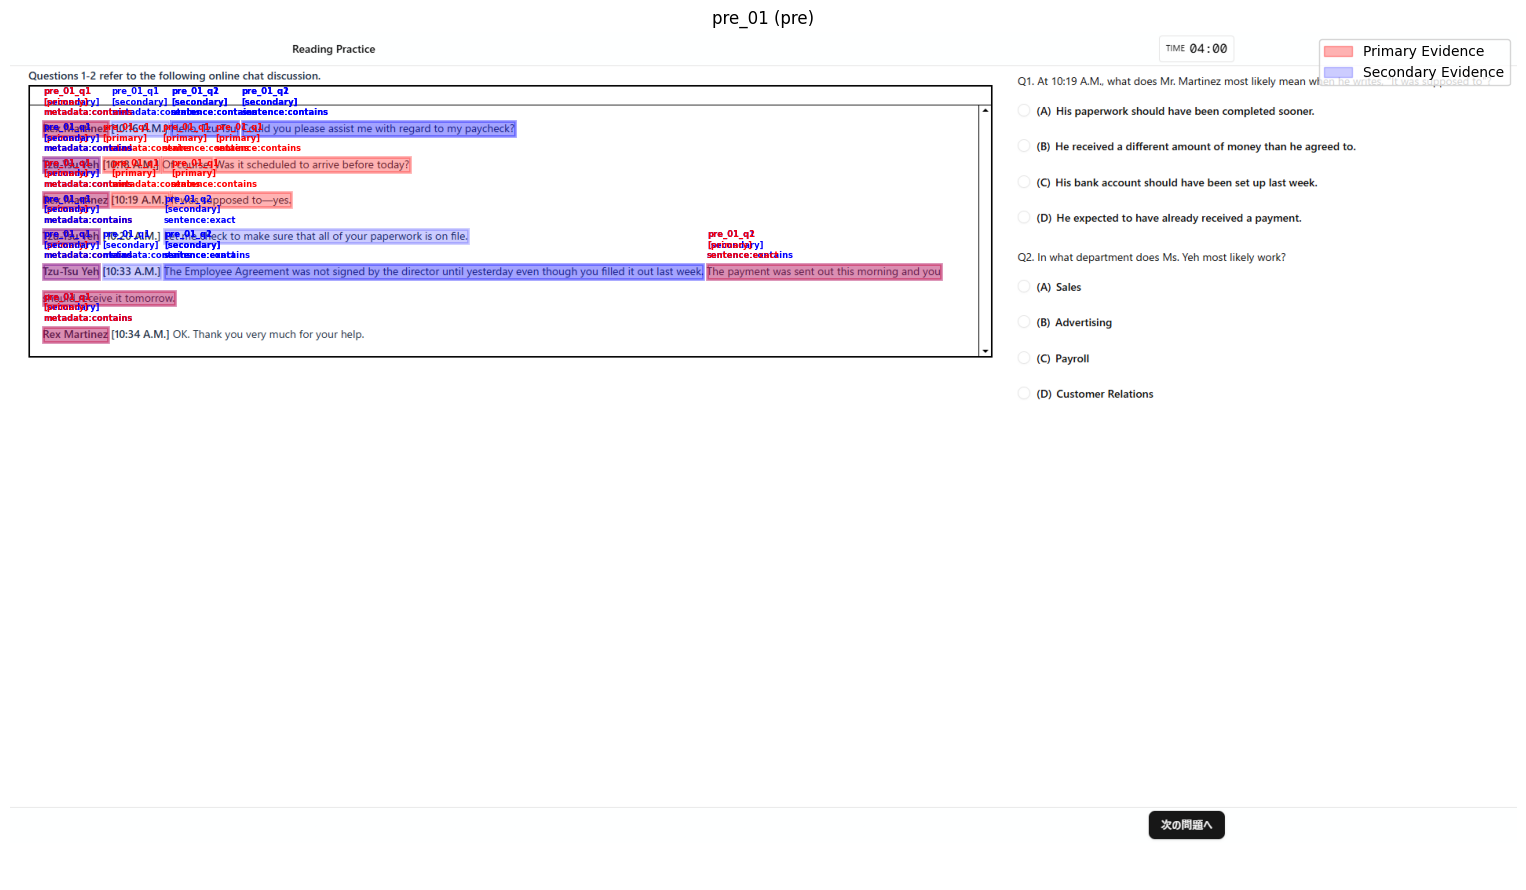


pre_02
  Image: 004_back.png
  pre_02_q1: 3 evidence sentences
  pre_02_q2: 2 evidence sentences


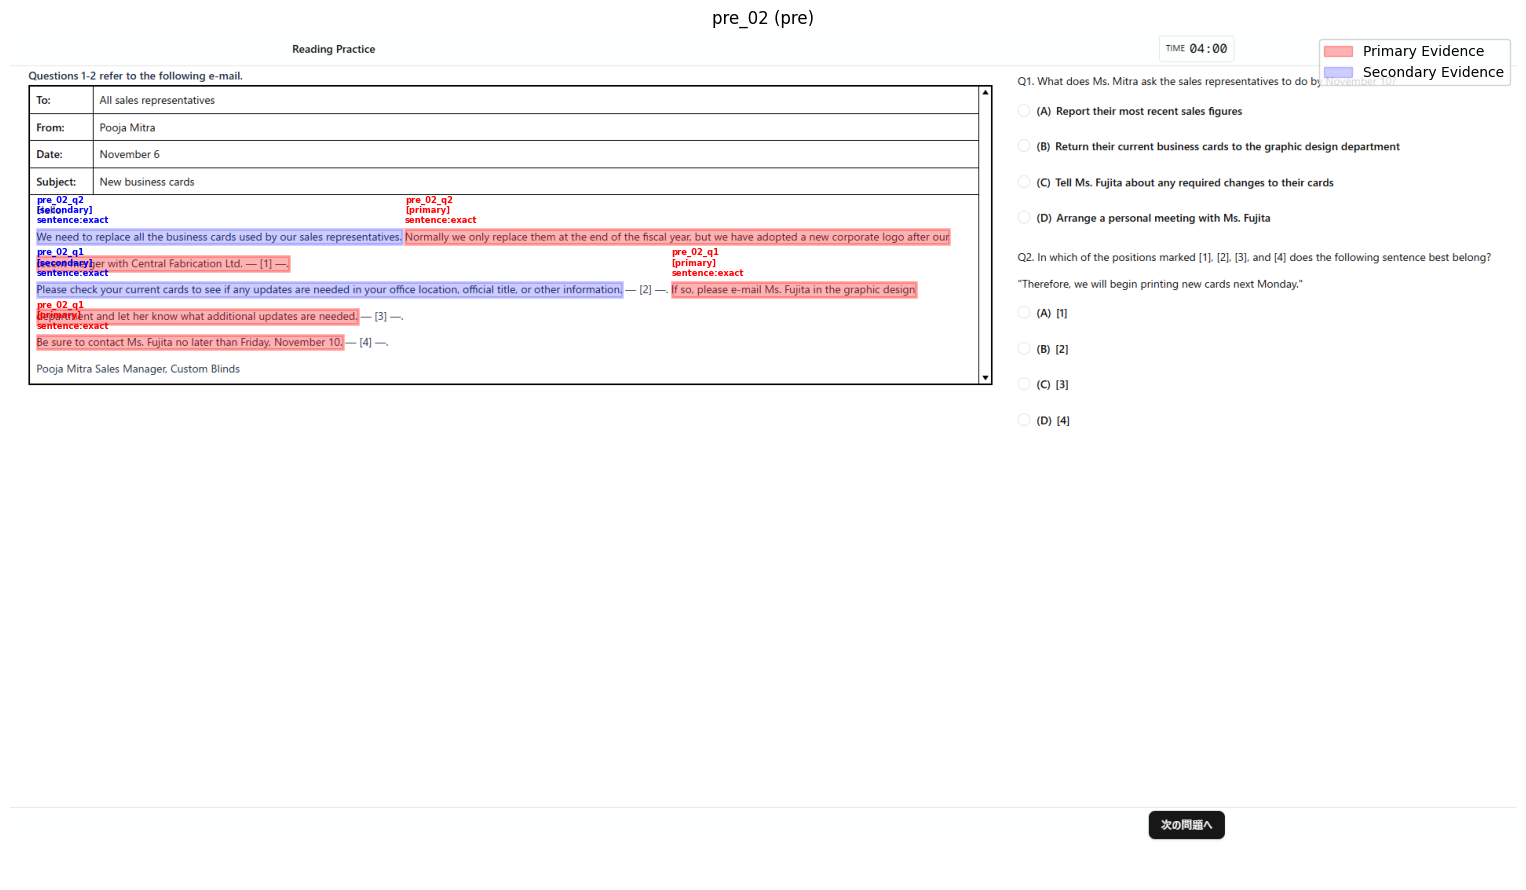


pre_03
  Image: 005_back.png
  pre_03_q1: 4 evidence sentences
  pre_03_q2: 2 evidence sentences
  pre_03_q3: 3 evidence sentences


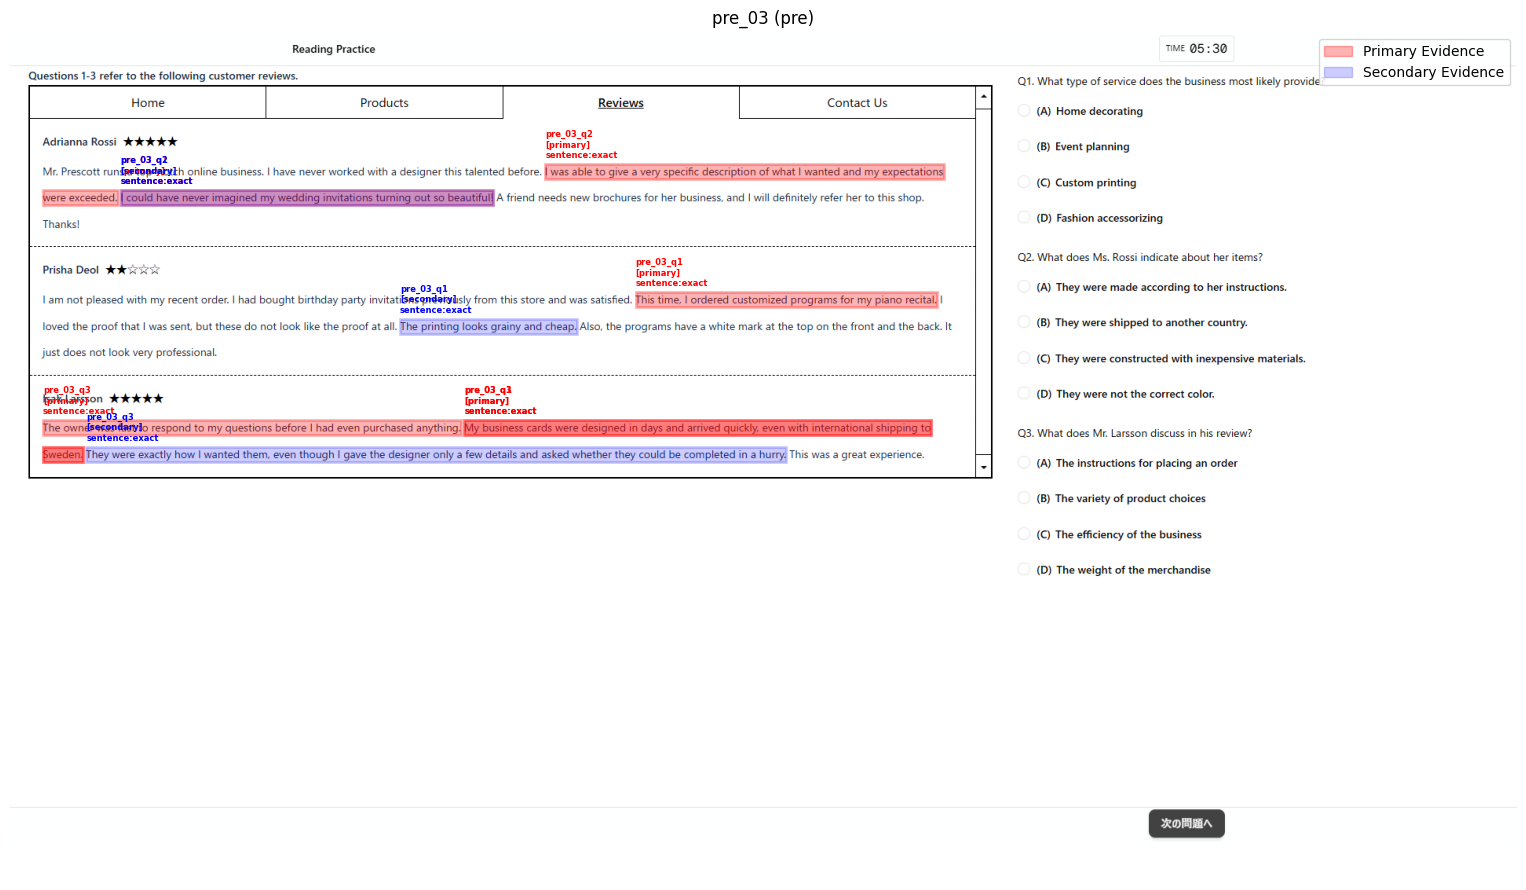


pre_04
  Image: 006_back.png
  pre_04_q1: 2 evidence sentences


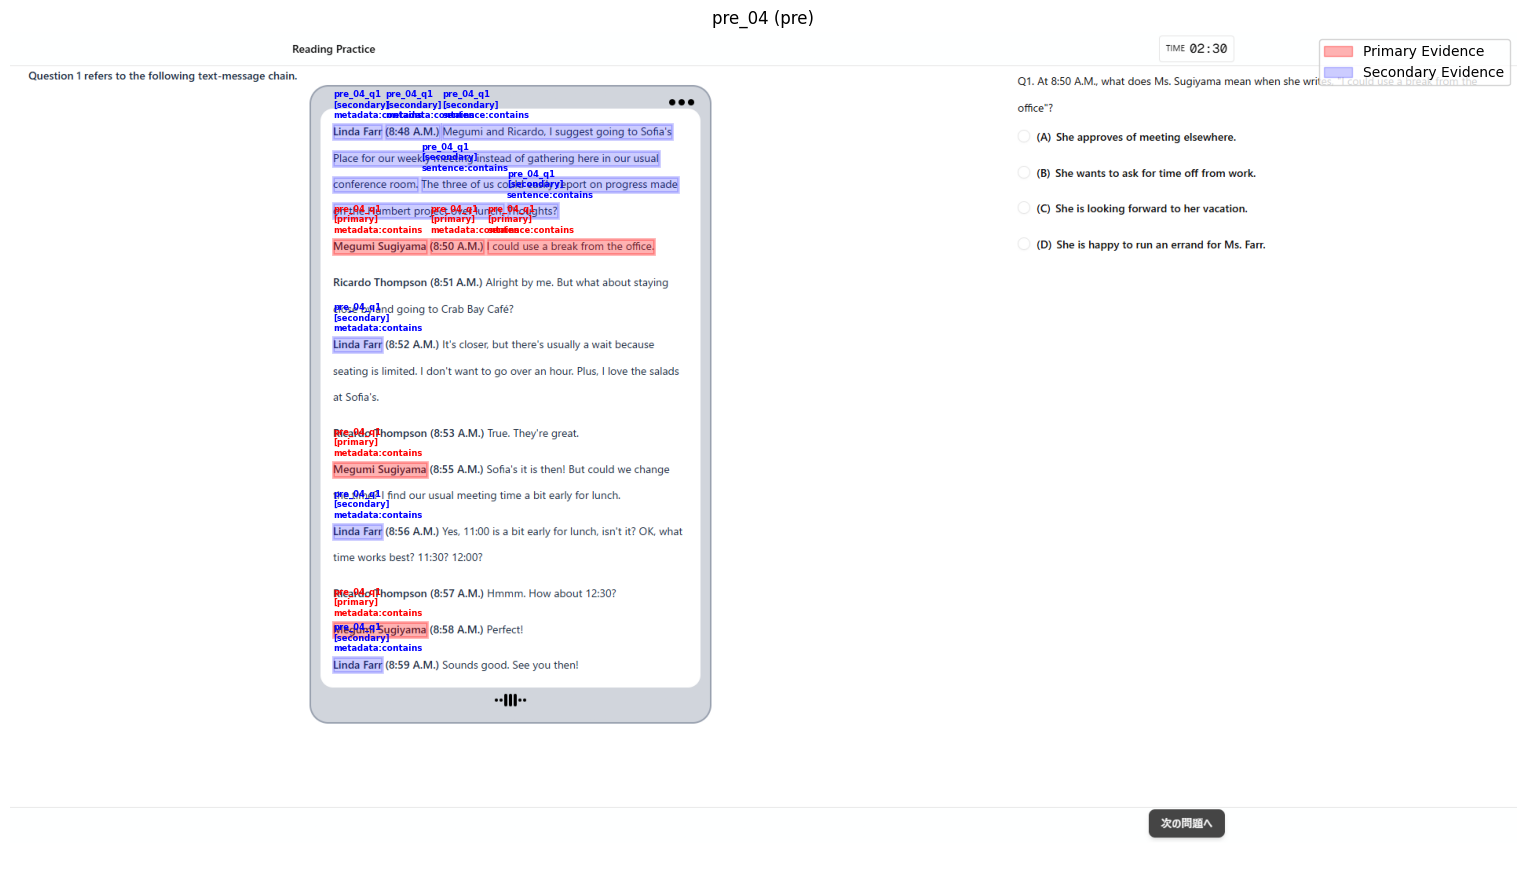


pre_05
  Image: 007_back.png
  pre_05_q1: 2 evidence sentences


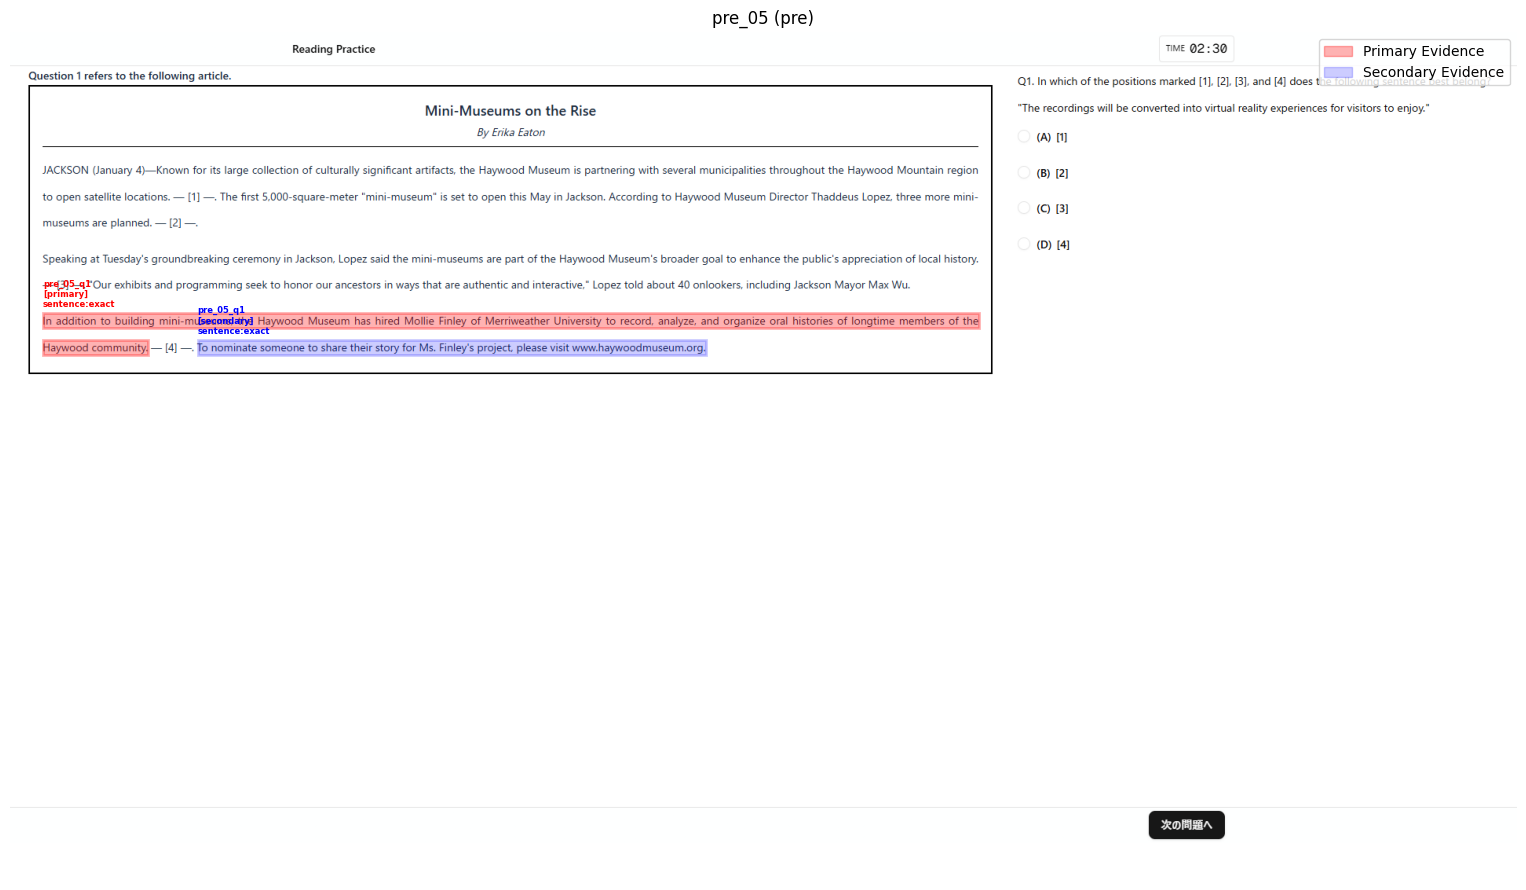


pre_06
  Image: 008_back.png
  pre_06_q1: 3 evidence sentences
  pre_06_q2: 2 evidence sentences
  pre_06_q3: 2 evidence sentences
  pre_06_q4: 3 evidence sentences


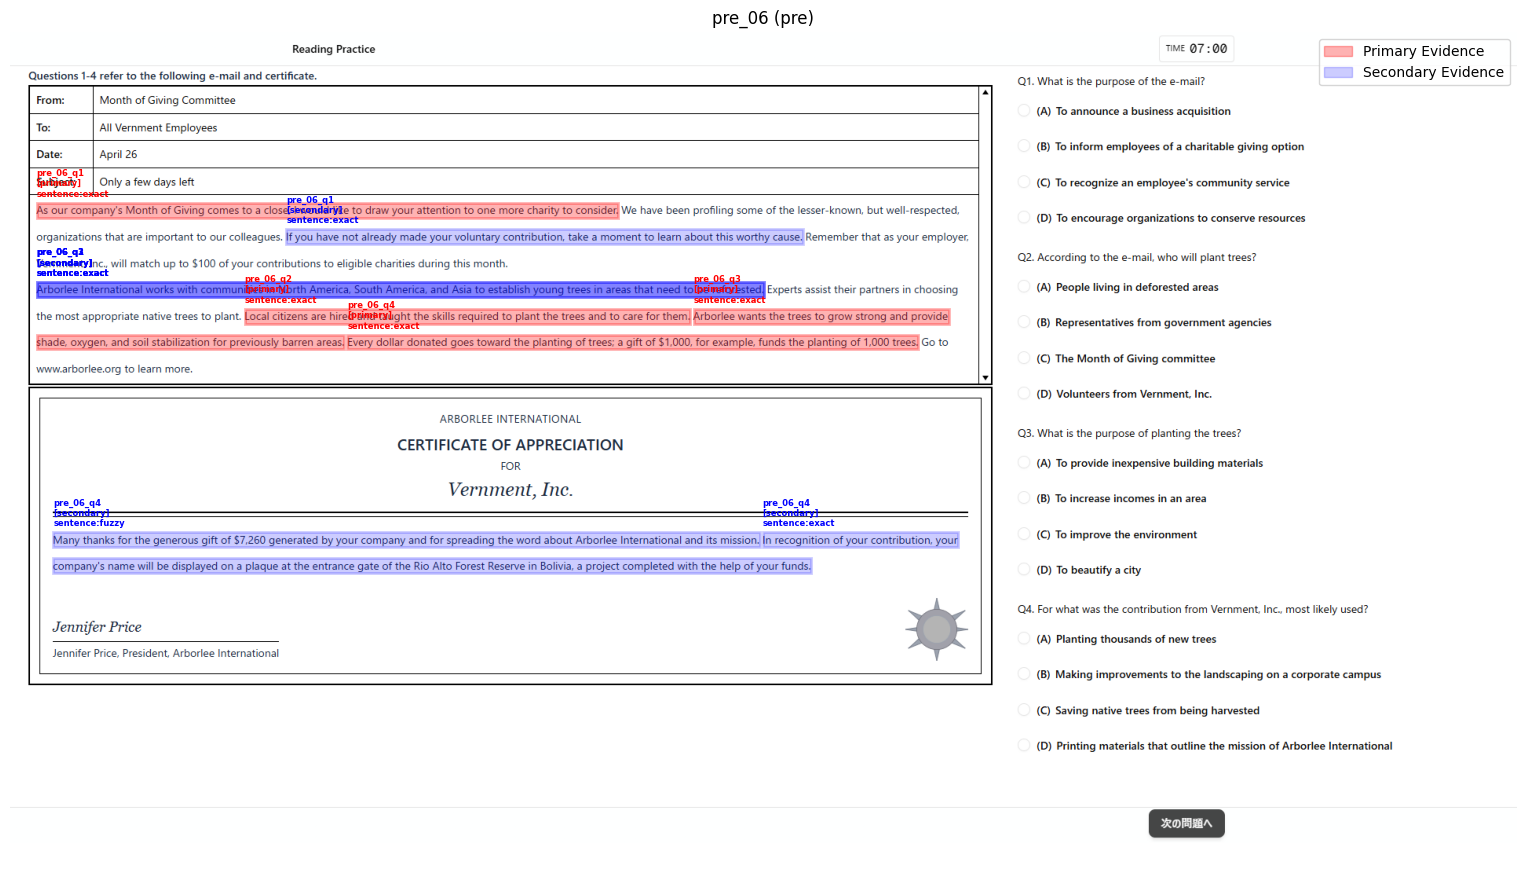


pre_07
  Image: 009_back.png
  pre_07_q1: 3 evidence sentences
  pre_07_q2: 2 evidence sentences
  pre_07_q3: 2 evidence sentences


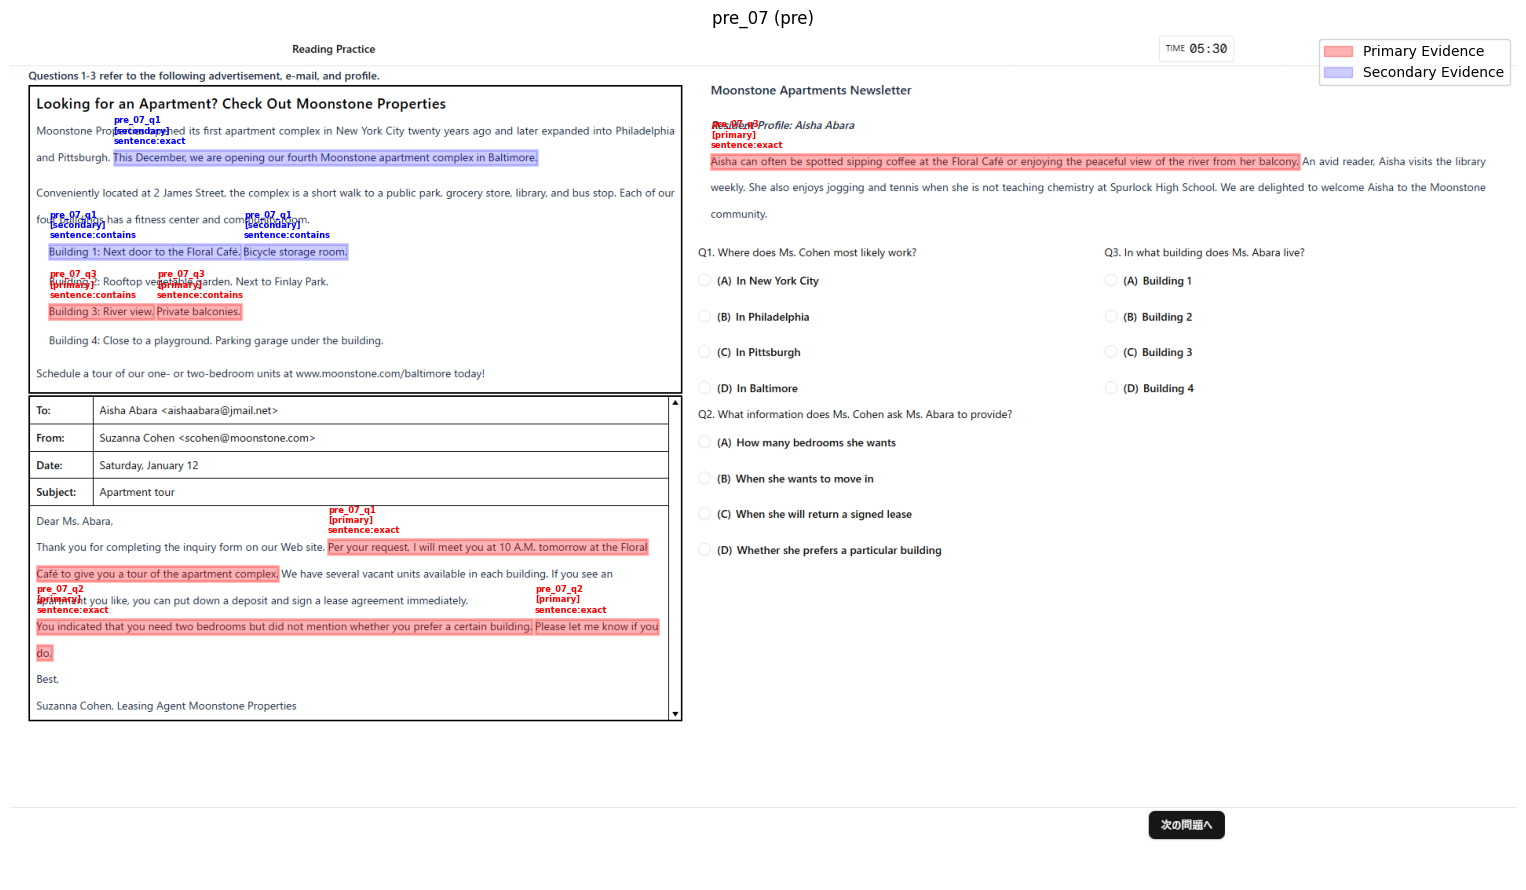


pre_08
  Image: 010_back.png
  pre_08_q1: 2 evidence sentences
  pre_08_q2: 3 evidence sentences
  pre_08_q3: 2 evidence sentences
  pre_08_q4: 4 evidence sentences


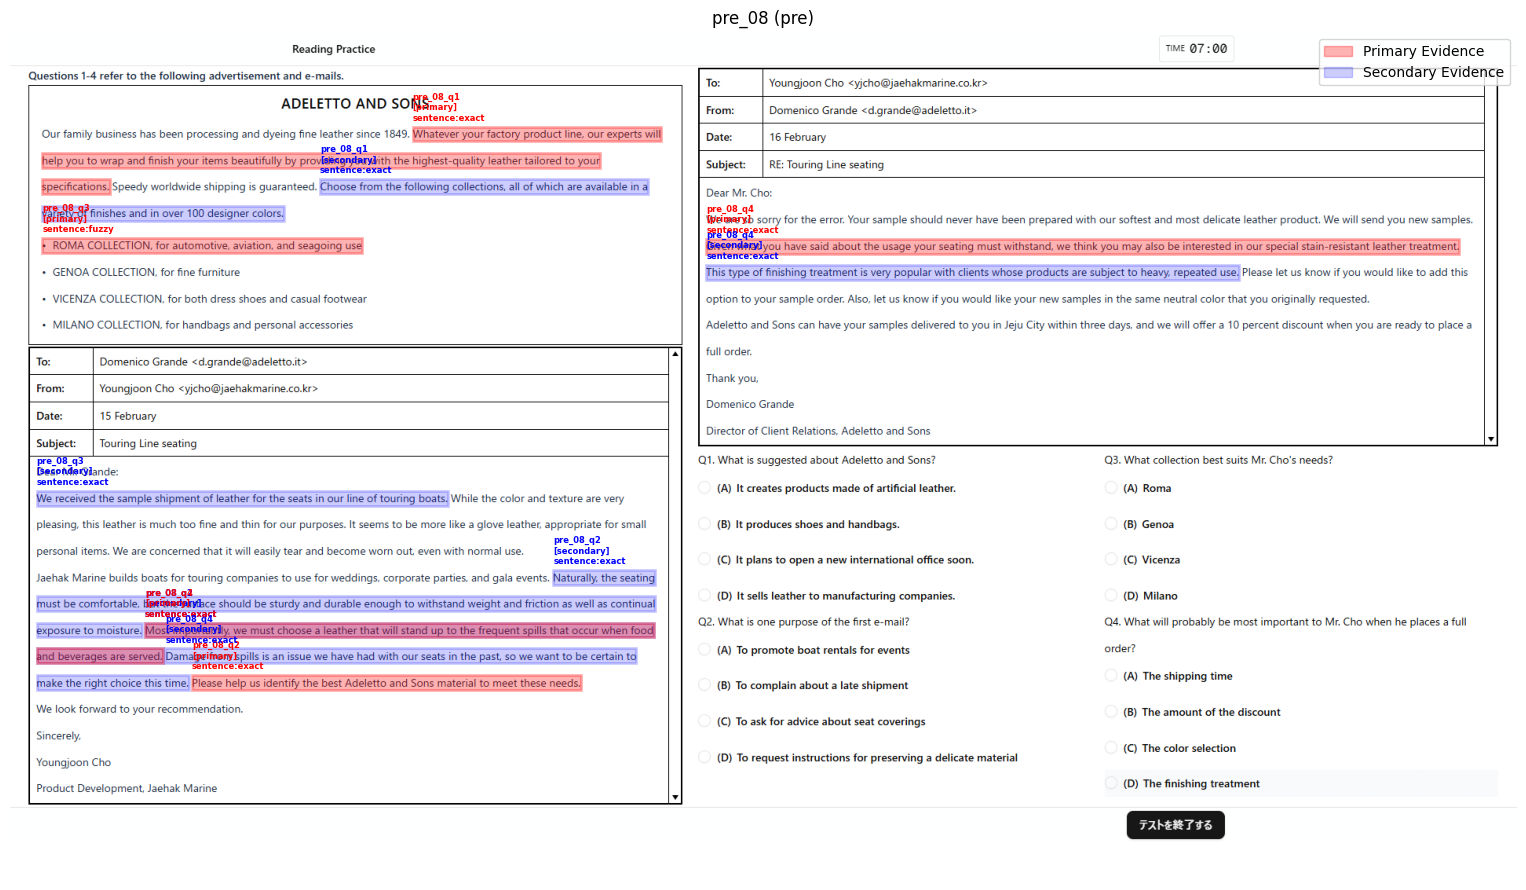

In [34]:
# === PRE phase ===
print('=== PRE phase ===')

for passage_id, passage_data in passages_by_phase.get('pre', []):
    phase = passage_data.get('phase', '')
    image_path = find_image_for_passage(passage_id, phase)
    
    print(f"\n{passage_id}")
    if image_path:
        print(f"  Image: {os.path.basename(image_path)}")
    else:
        print("  Image: NOT FOUND")
    
    # 設問ごとの根拠数を表示
    for q_id, q_data in passage_data.get('questions', {}).items():
        evidence_count = len(q_data.get('evidence_sentences', []))
        print(f"  {q_id}: {evidence_count} evidence sentences")
    
    fig = visualize_evidence(passage_id, passage_data, image_path)
    plt.show()
    plt.close()

=== POST phase ===

post_01
  Image: 003_back.png
  post_01_q1: 3 evidence sentences
  post_01_q2: 4 evidence sentences


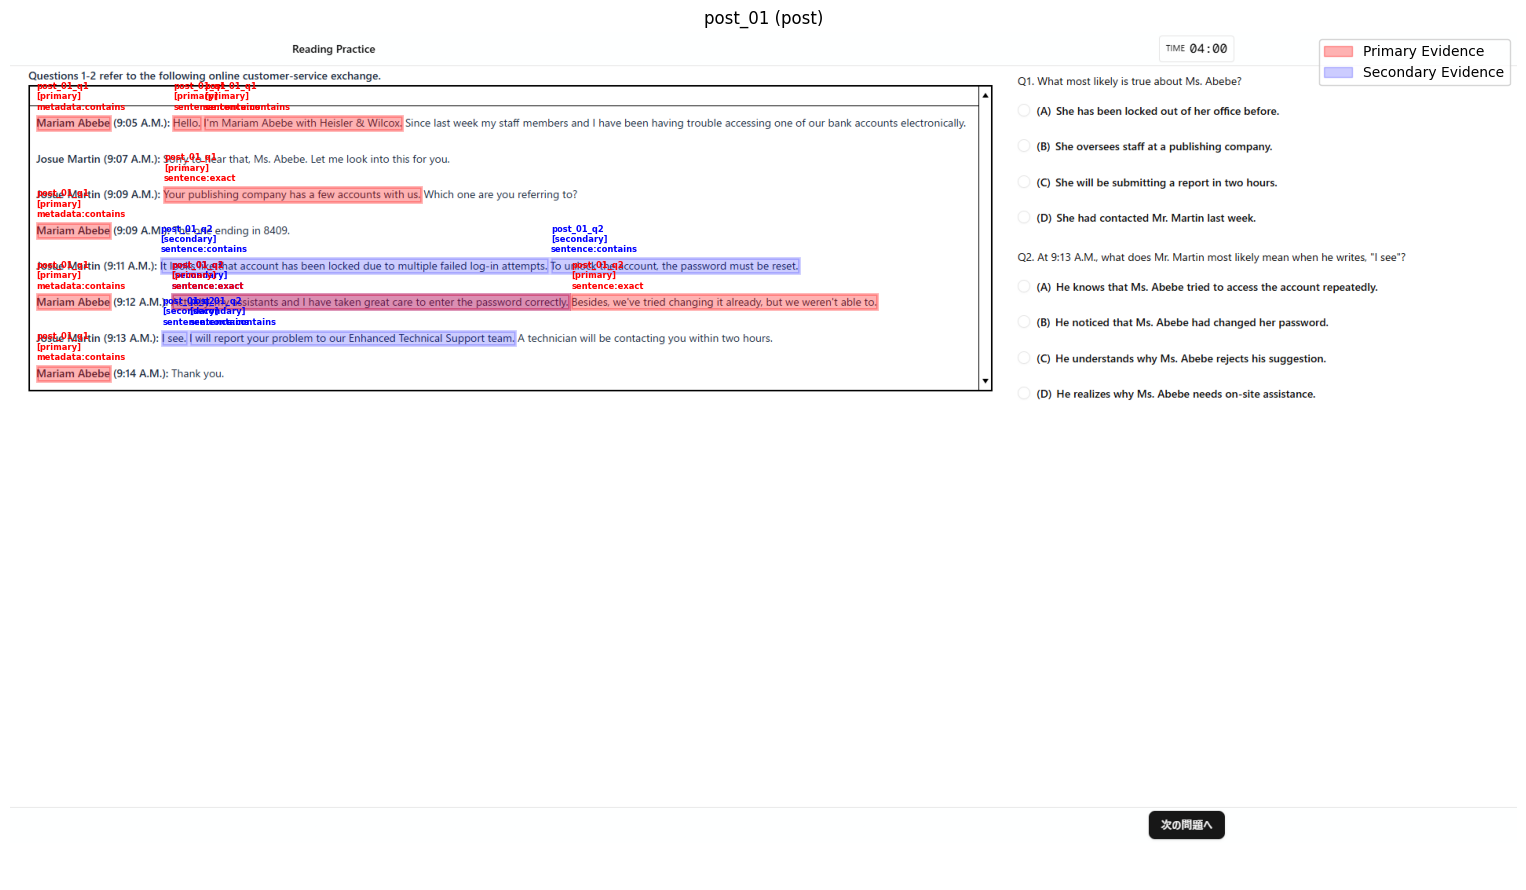


post_02
  Image: 004_back.png
  post_02_q1: 4 evidence sentences
  post_02_q2: 2 evidence sentences


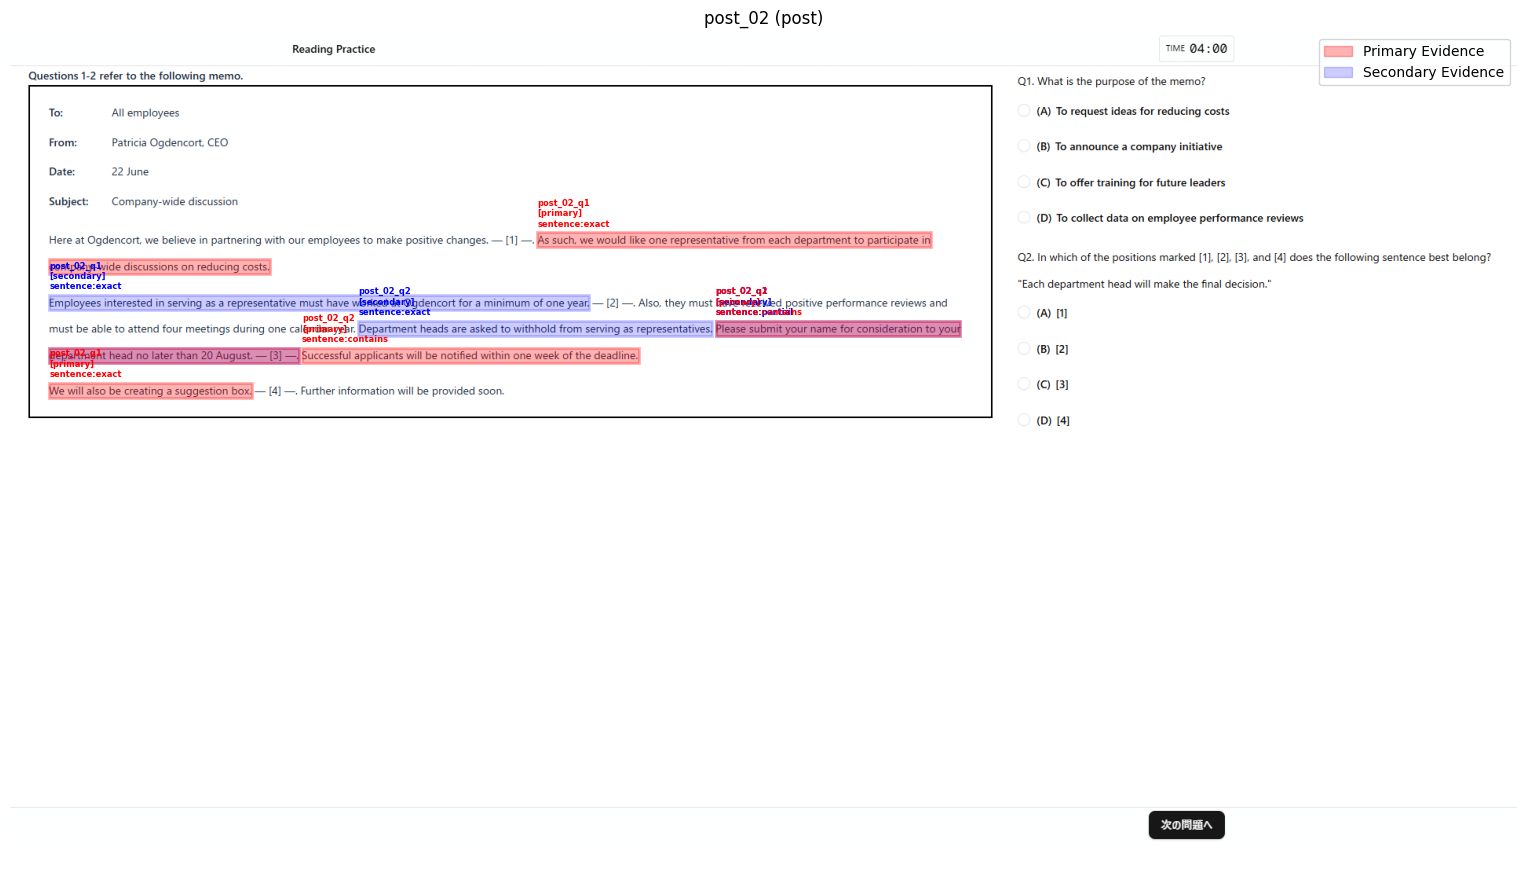


post_03
  Image: 005_back.png
  post_03_q1: 2 evidence sentences
  post_03_q2: 2 evidence sentences
  post_03_q3: 3 evidence sentences


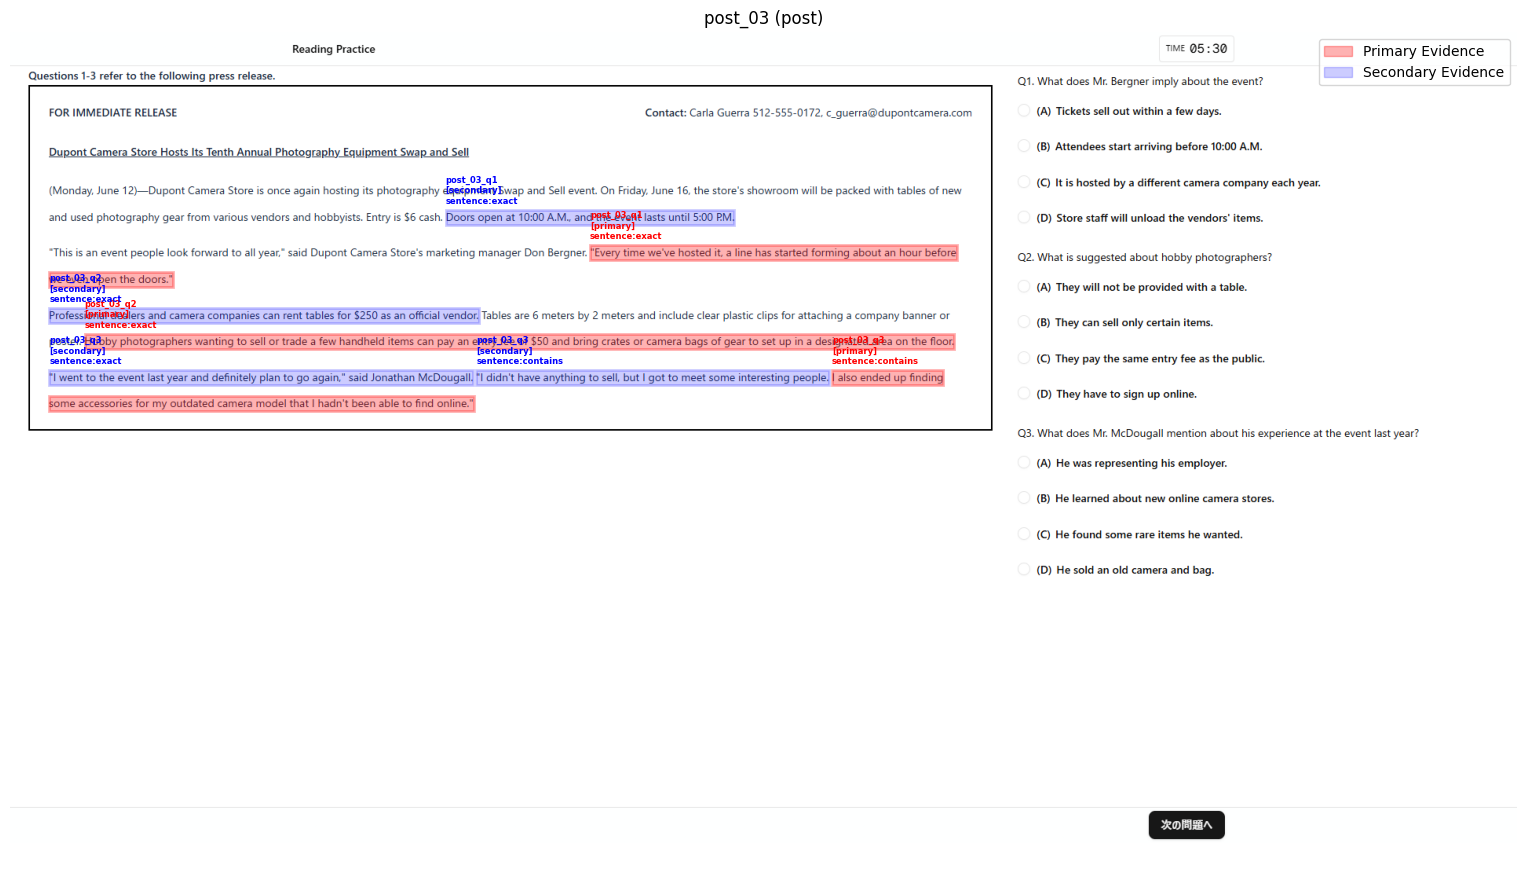


post_04
  Image: 006_back.png
  post_04_q1: 3 evidence sentences
  post_04_q2: 3 evidence sentences


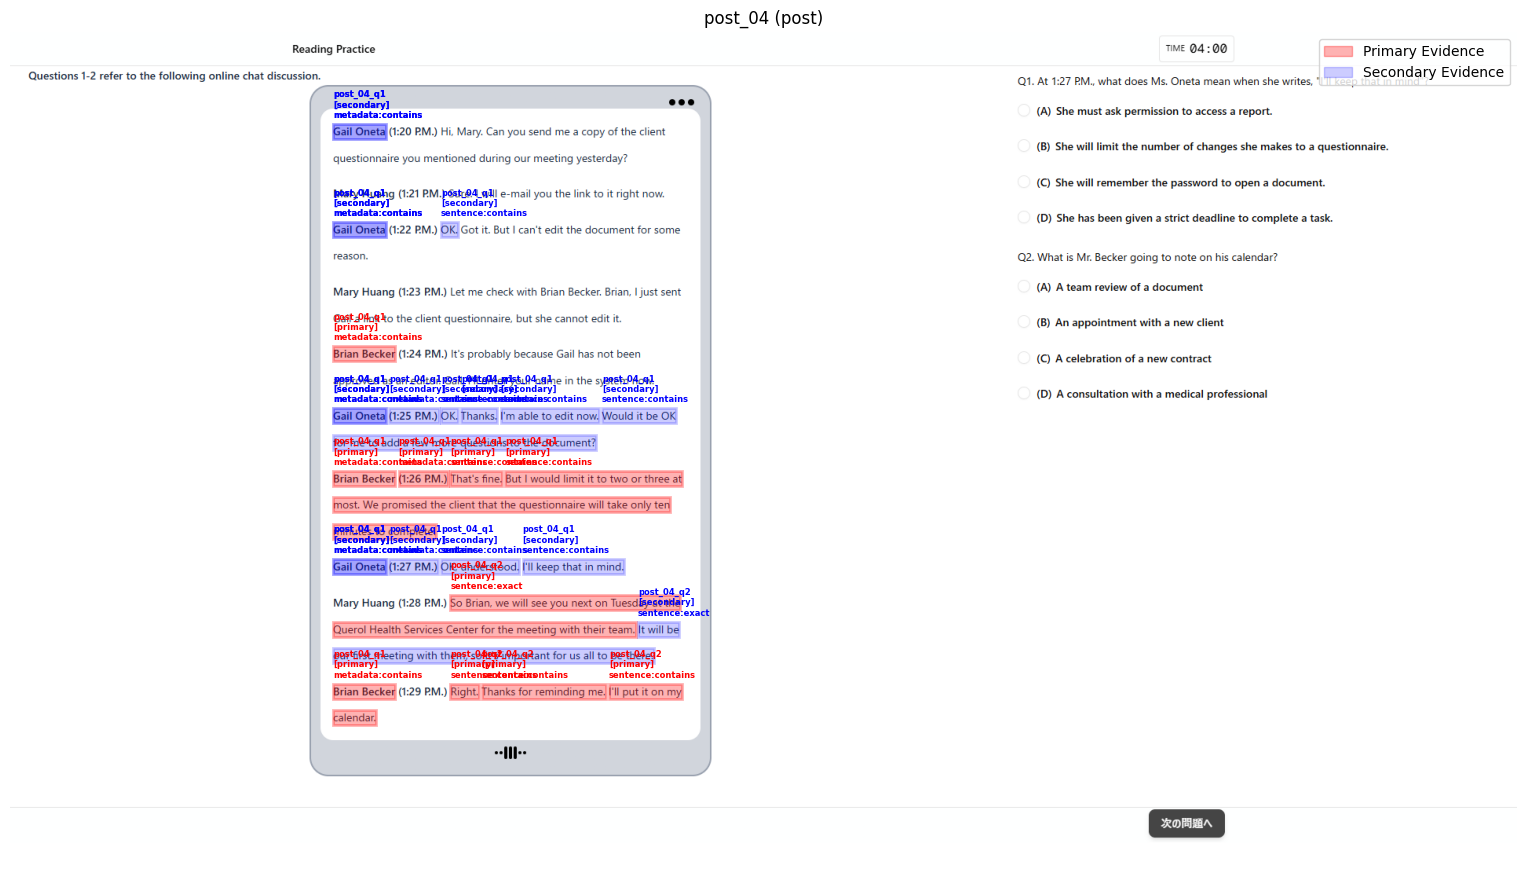


post_05
  Image: 007_back.png
  post_05_q1: 2 evidence sentences


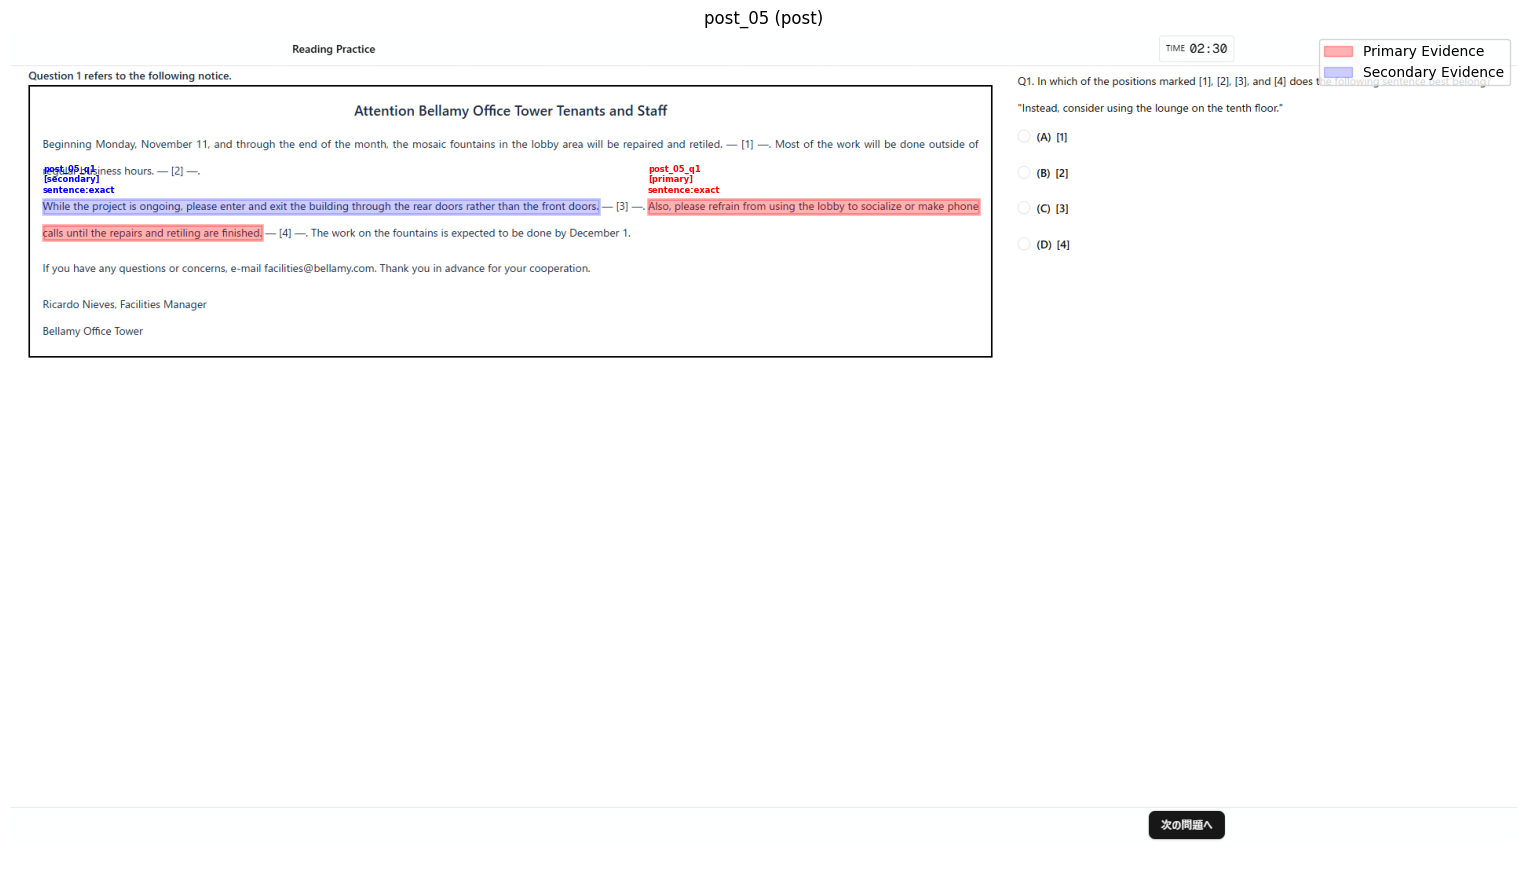


post_06
  Image: 008_back.png
  post_06_q1: 3 evidence sentences
  post_06_q2: 2 evidence sentences
  post_06_q3: 4 evidence sentences


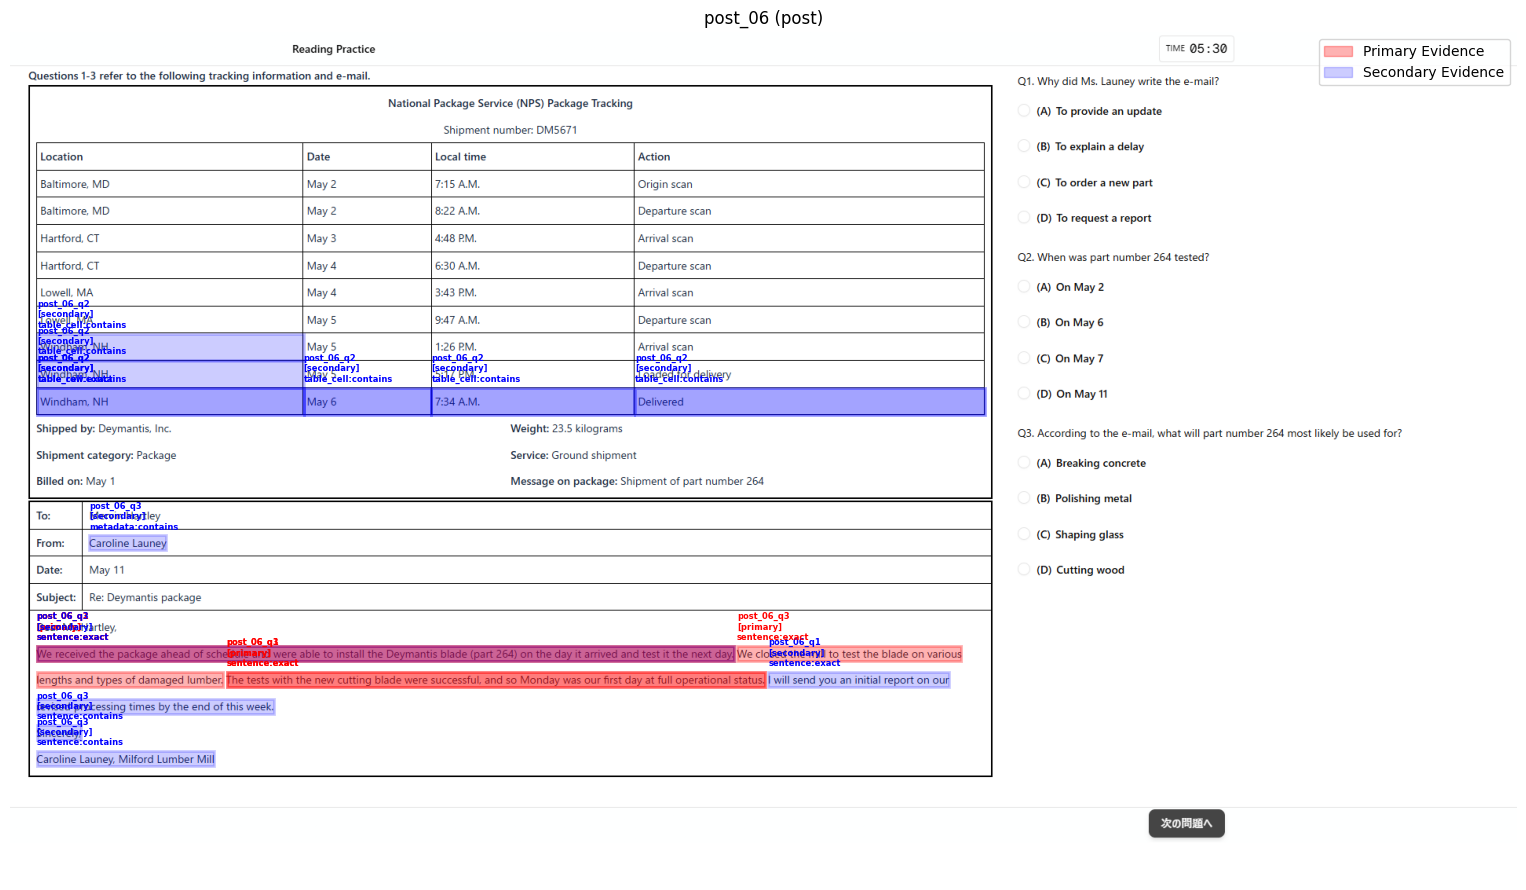


post_07
  Image: 009_back.png
  post_07_q1: 3 evidence sentences
  post_07_q2: 3 evidence sentences
  post_07_q3: 2 evidence sentences


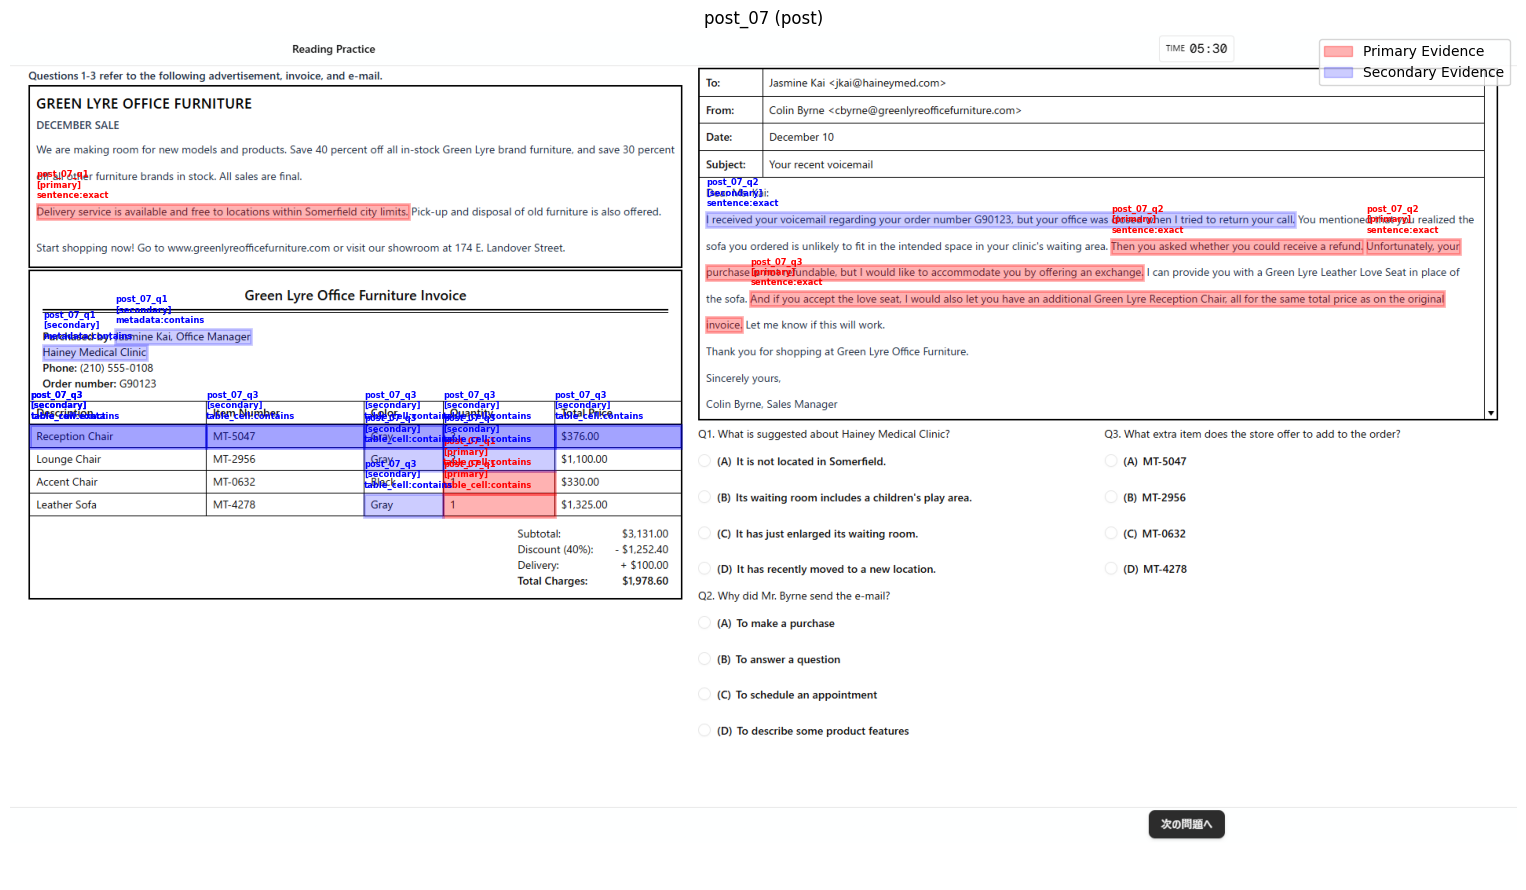


post_08
  Image: 010_back.png
  post_08_q1: 3 evidence sentences
  post_08_q2: 2 evidence sentences
  post_08_q3: 2 evidence sentences
  post_08_q4: 3 evidence sentences


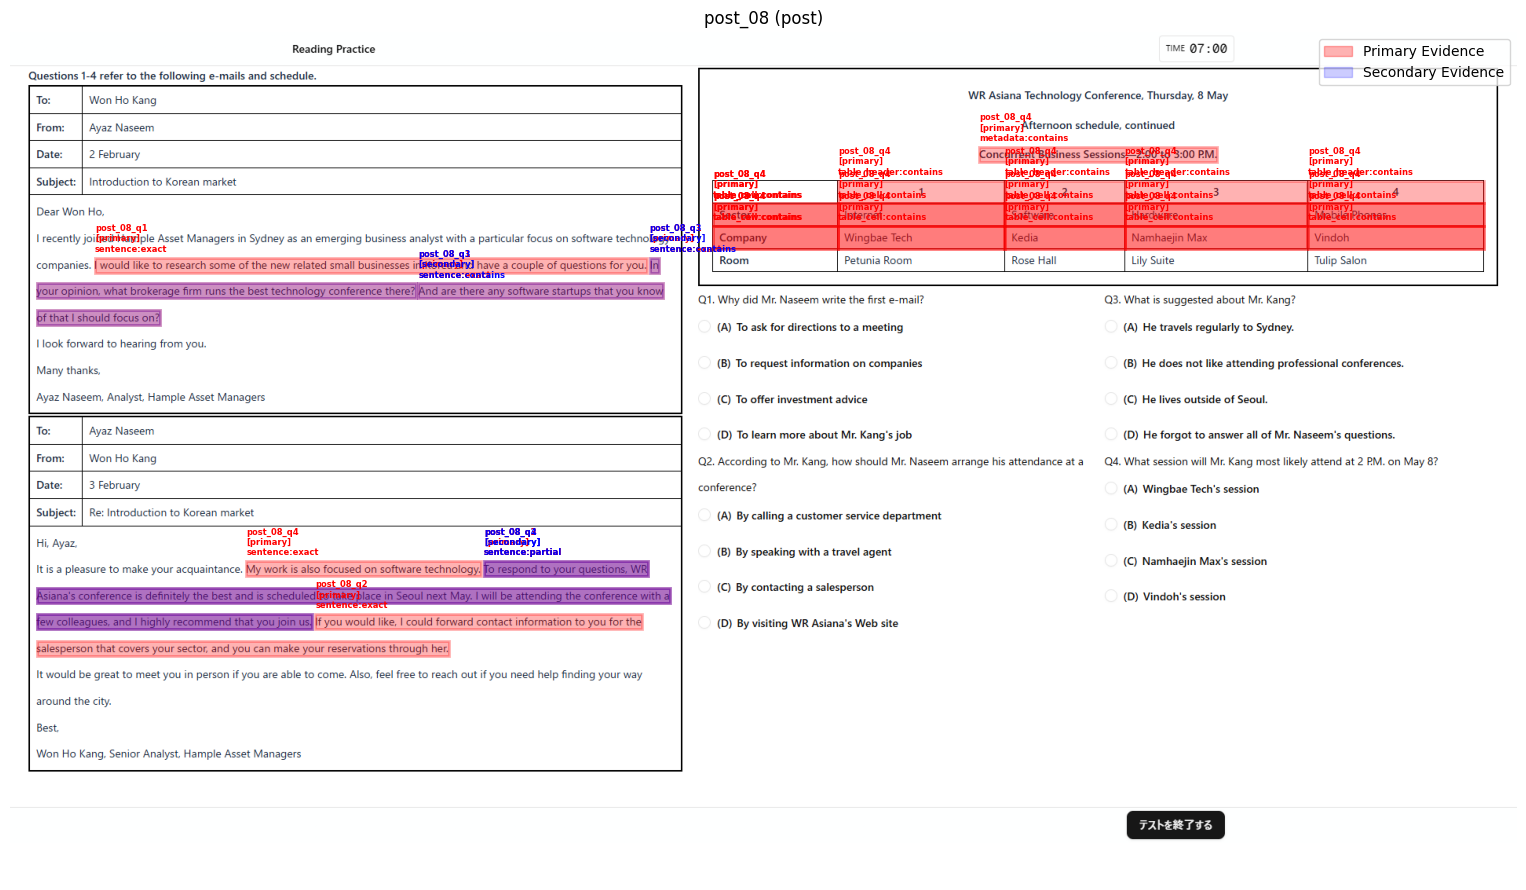

In [35]:
# === POST phase ===
print('=== POST phase ===')

for passage_id, passage_data in passages_by_phase.get('post', []):
    phase = passage_data.get('phase', '')
    image_path = find_image_for_passage(passage_id, phase)
    
    print(f"\n{passage_id}")
    if image_path:
        print(f"  Image: {os.path.basename(image_path)}")
    else:
        print("  Image: NOT FOUND")
    
    # 設問ごとの根拠数を表示
    for q_id, q_data in passage_data.get('questions', {}).items():
        evidence_count = len(q_data.get('evidence_sentences', []))
        print(f"  {q_id}: {evidence_count} evidence sentences")
    
    fig = visualize_evidence(passage_id, passage_data, image_path)
    plt.show()
    plt.close()

=== TRAINING1 phase ===

tr_01
  Image: 003_back.png
  tr_01_q1: 3 evidence sentences
  tr_01_q2: 2 evidence sentences


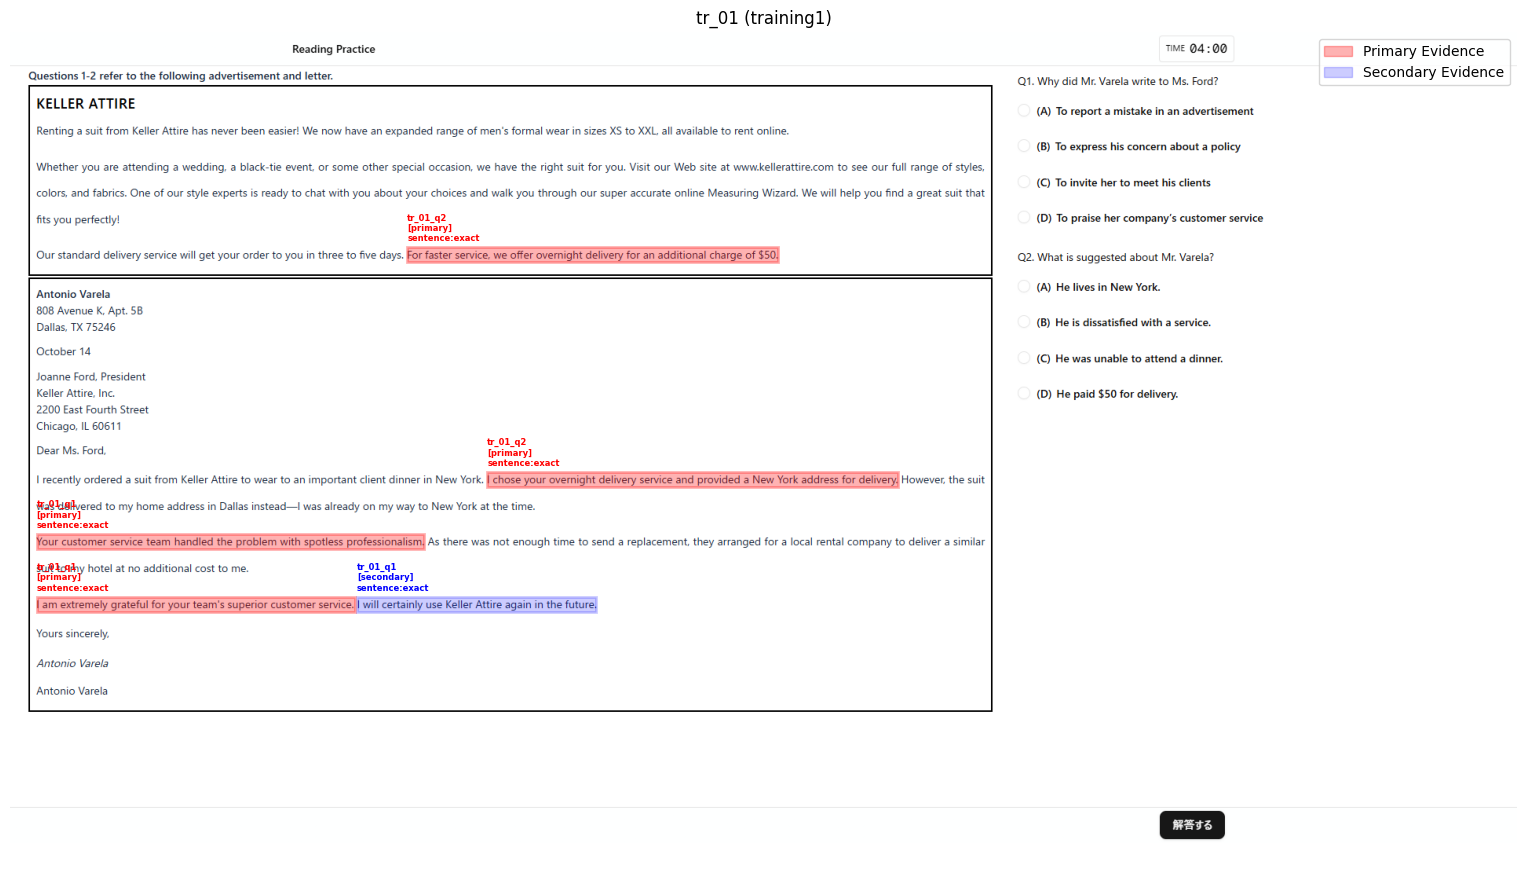


tr_01_an1
  Image: 007_back.png
  tr_01_an1_q1: 3 evidence sentences
  tr_01_an1_q2: 2 evidence sentences
  tr_01_an1_q3: 2 evidence sentences


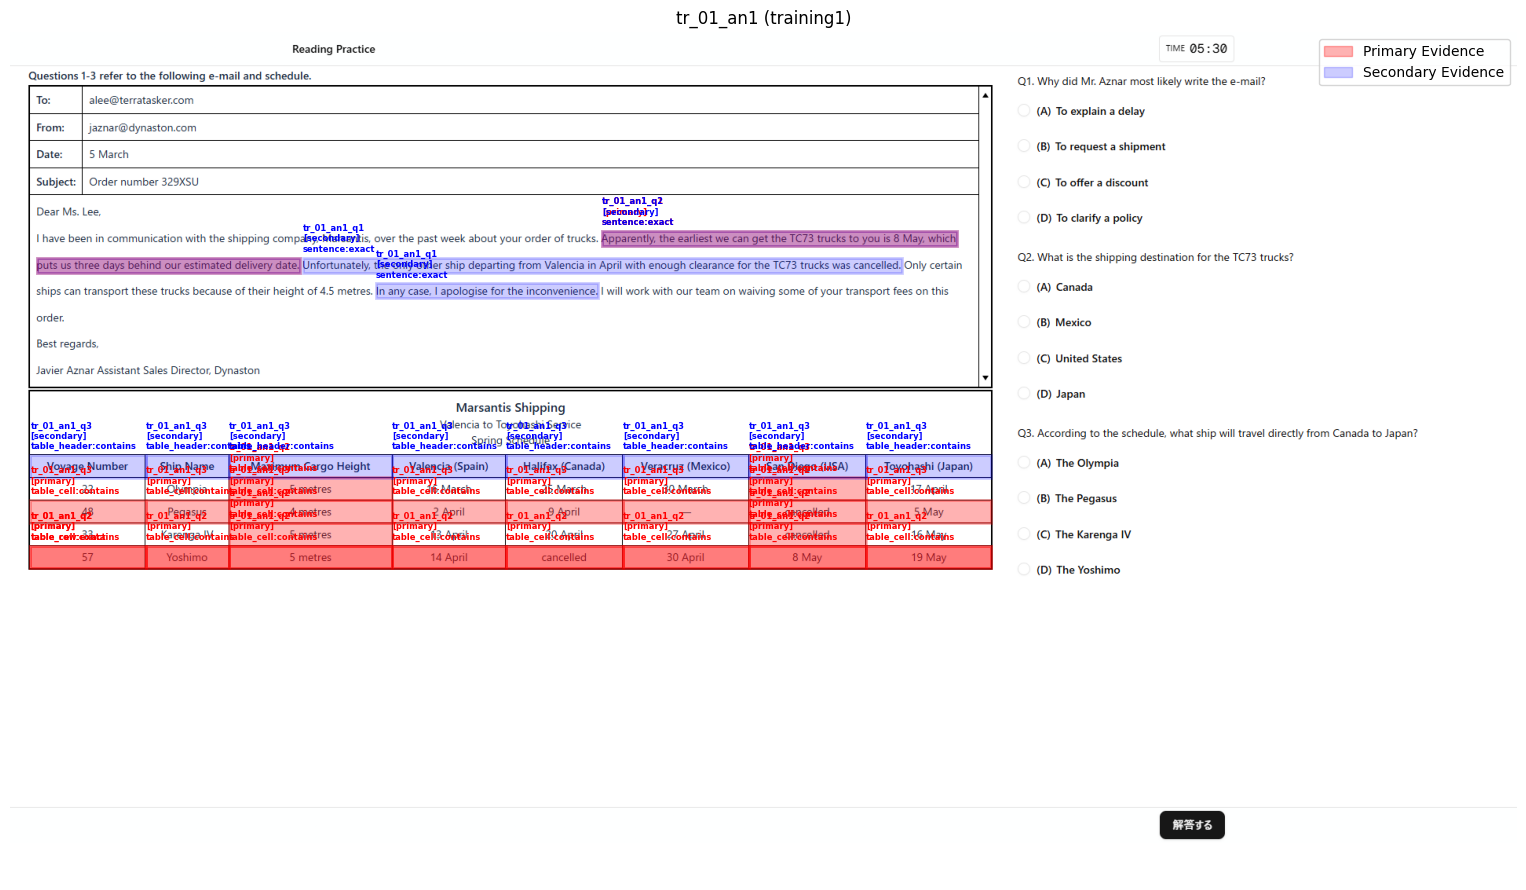


tr_01_an2
  Image: 009_back.png
  tr_01_an2_q1: 2 evidence sentences
  tr_01_an2_q2: 3 evidence sentences


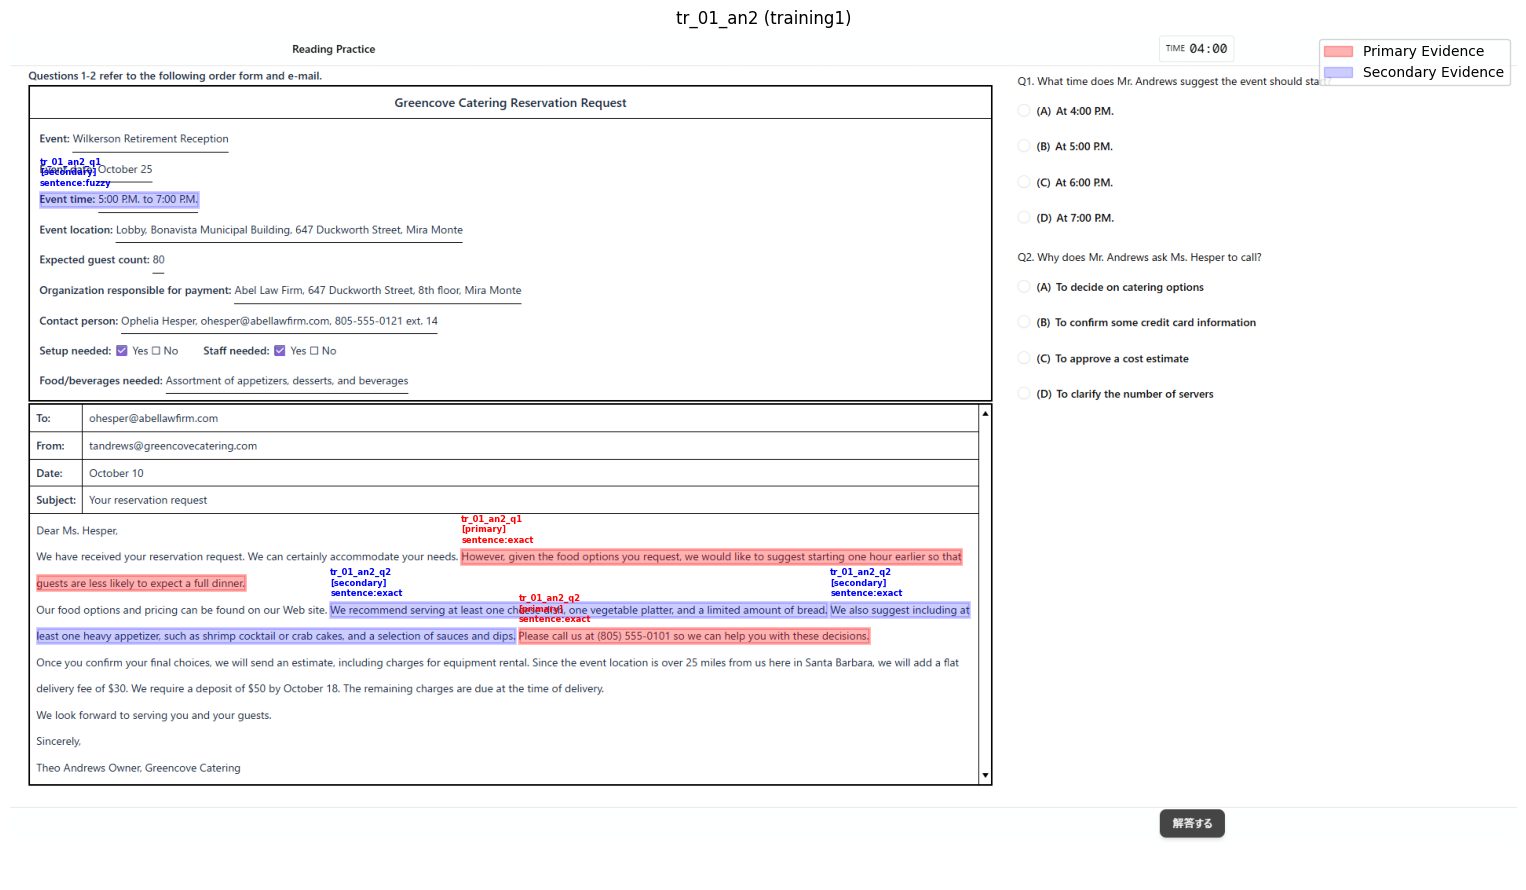


tr_01_an3
  Image: 011_back.png
  tr_01_an3_q1: 3 evidence sentences
  tr_01_an3_q2: 3 evidence sentences
  tr_01_an3_q3: 3 evidence sentences


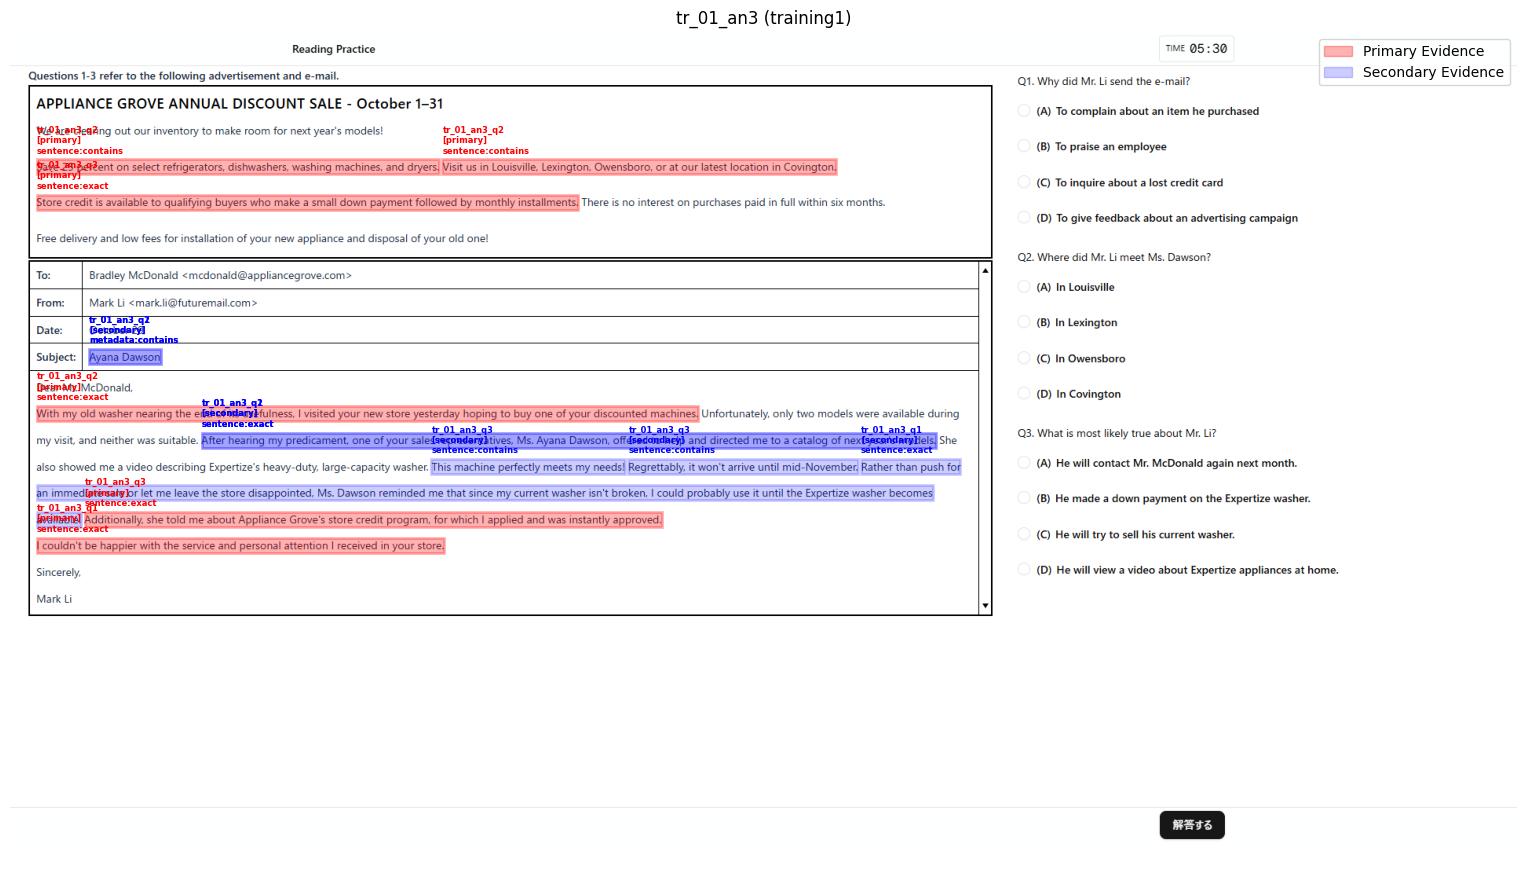

In [36]:
# === TRAINING1 phase ===
print('=== TRAINING1 phase ===')

for passage_id, passage_data in passages_by_phase.get('training1', []):
    phase = passage_data.get('phase', '')
    image_path = find_image_for_passage(passage_id, phase)
    
    print(f"\n{passage_id}")
    if image_path:
        print(f"  Image: {os.path.basename(image_path)}")
    else:
        print("  Image: NOT FOUND")
    
    # 設問ごとの根拠数を表示
    for q_id, q_data in passage_data.get('questions', {}).items():
        evidence_count = len(q_data.get('evidence_sentences', []))
        print(f"  {q_id}: {evidence_count} evidence sentences")
    
    fig = visualize_evidence(passage_id, passage_data, image_path)
    plt.show()
    plt.close()

=== TRAINING2 phase ===

tr_02
  Image: 003_back.png
  tr02_q1: 3 evidence sentences
  tr02_q2: 3 evidence sentences
  tr02_q3: 3 evidence sentences


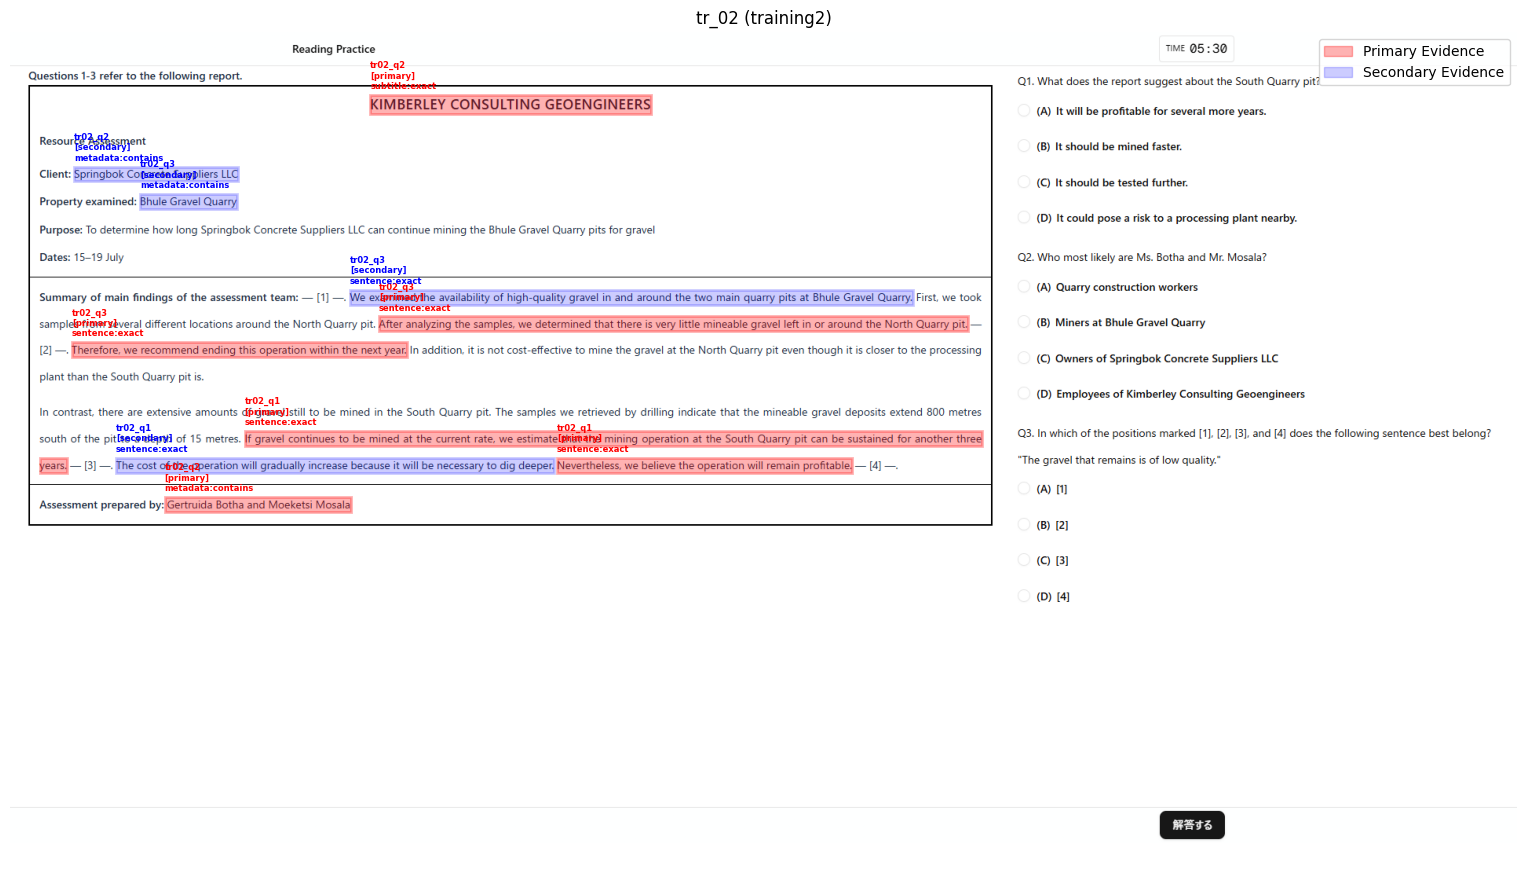


tr_02_an1
  Image: 007_back.png
  tr_02_an1_q1: 1 evidence sentences
  tr_02_an1_q2: 2 evidence sentences


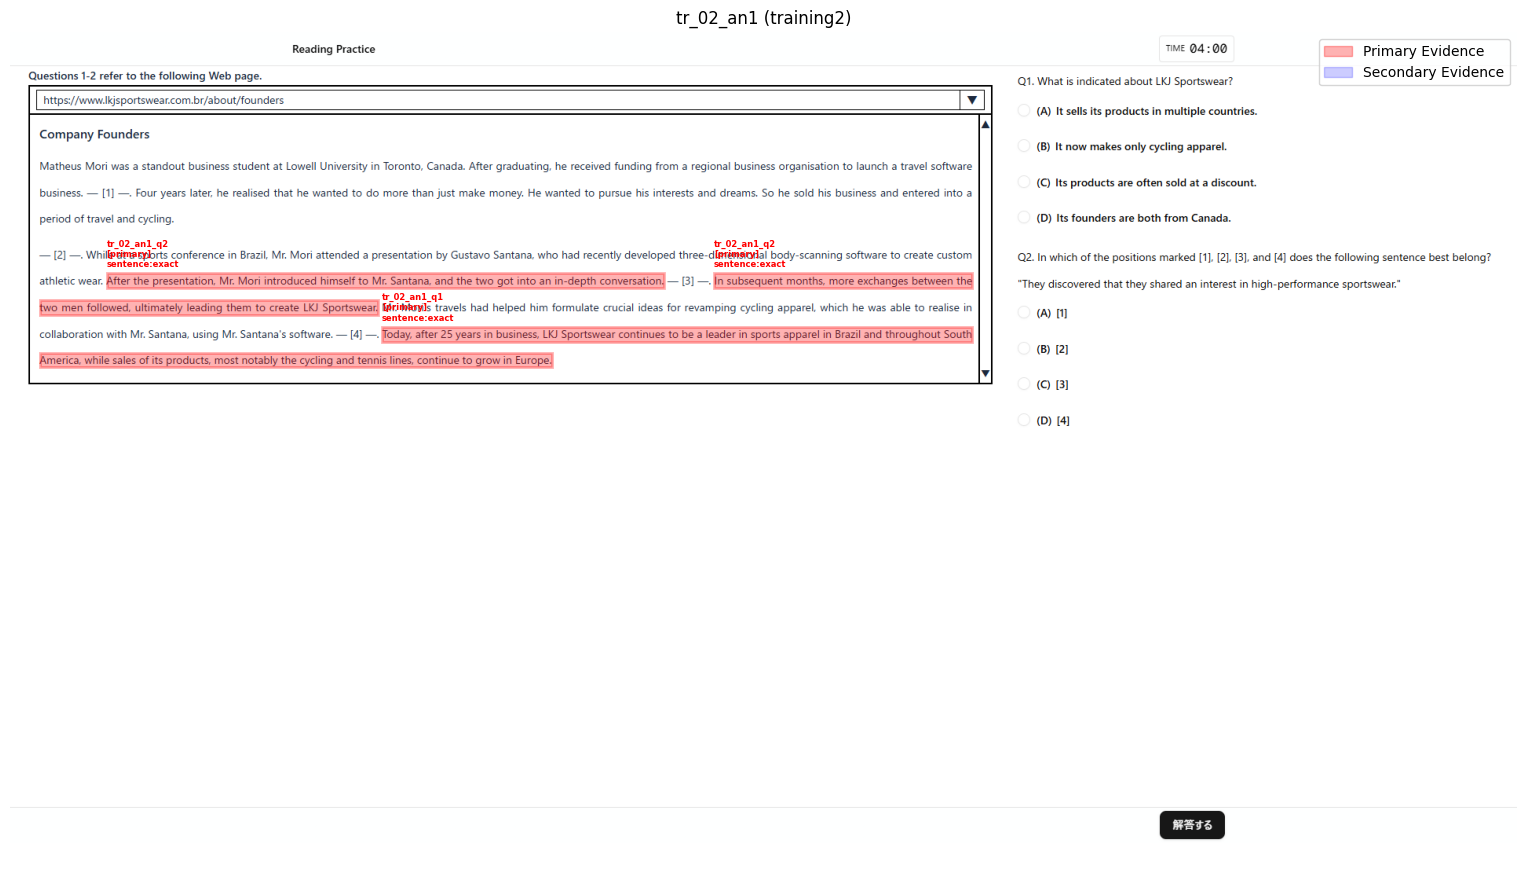


tr_02_an2
  Image: 009_back.png
  tr_02_an2_q1: 2 evidence sentences
  tr_02_an2_q2: 2 evidence sentences
  tr_02_an2_q3: 3 evidence sentences


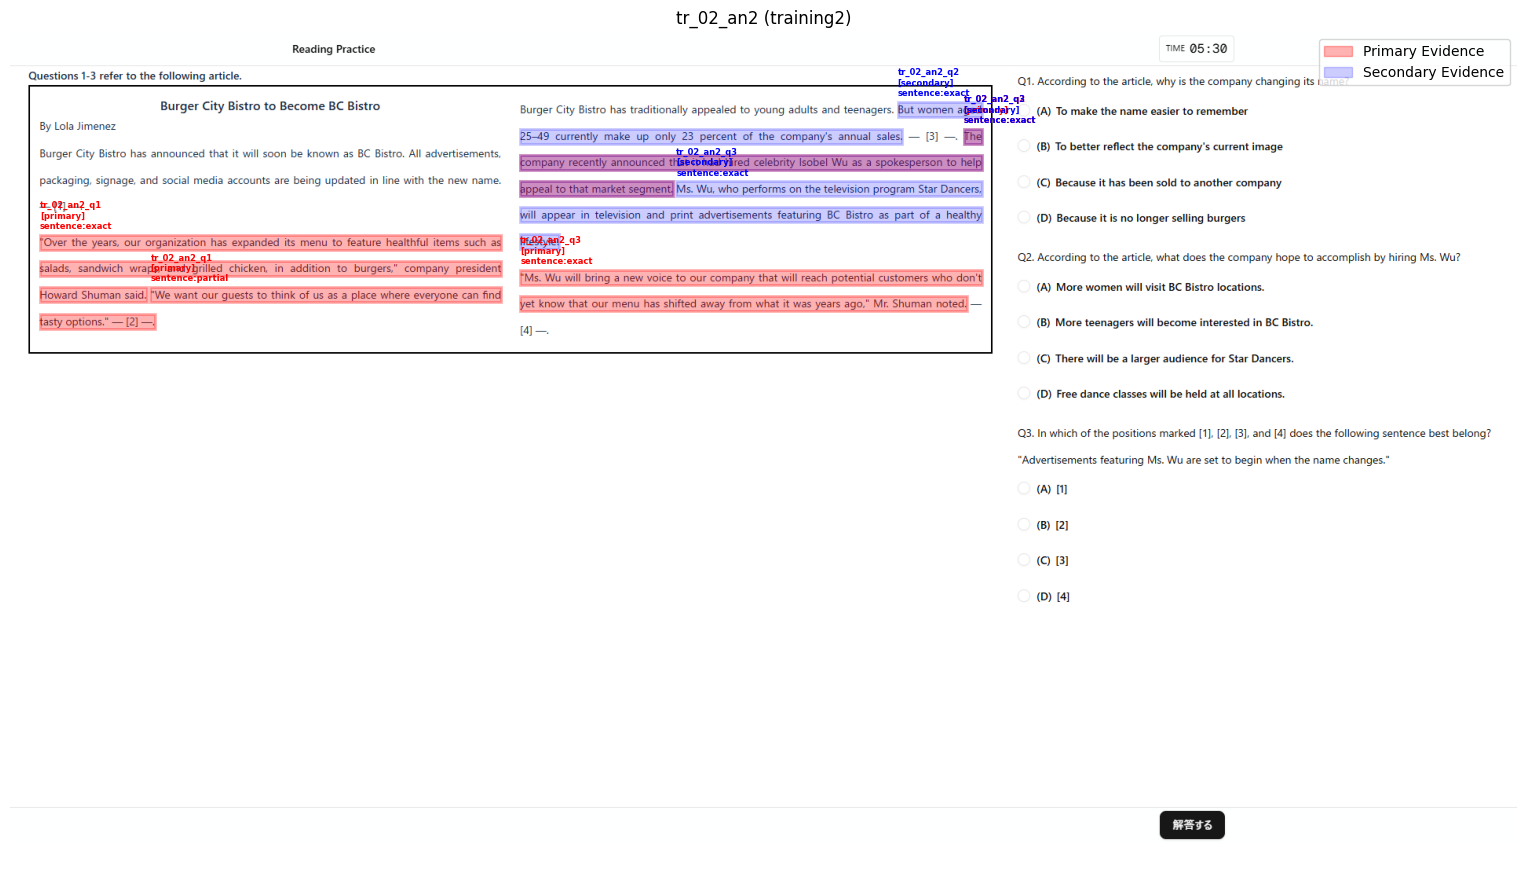


tr_02_an3
  Image: 011_back.png
  tr_02_an3_q1: 4 evidence sentences
  tr_02_an3_q2: 3 evidence sentences


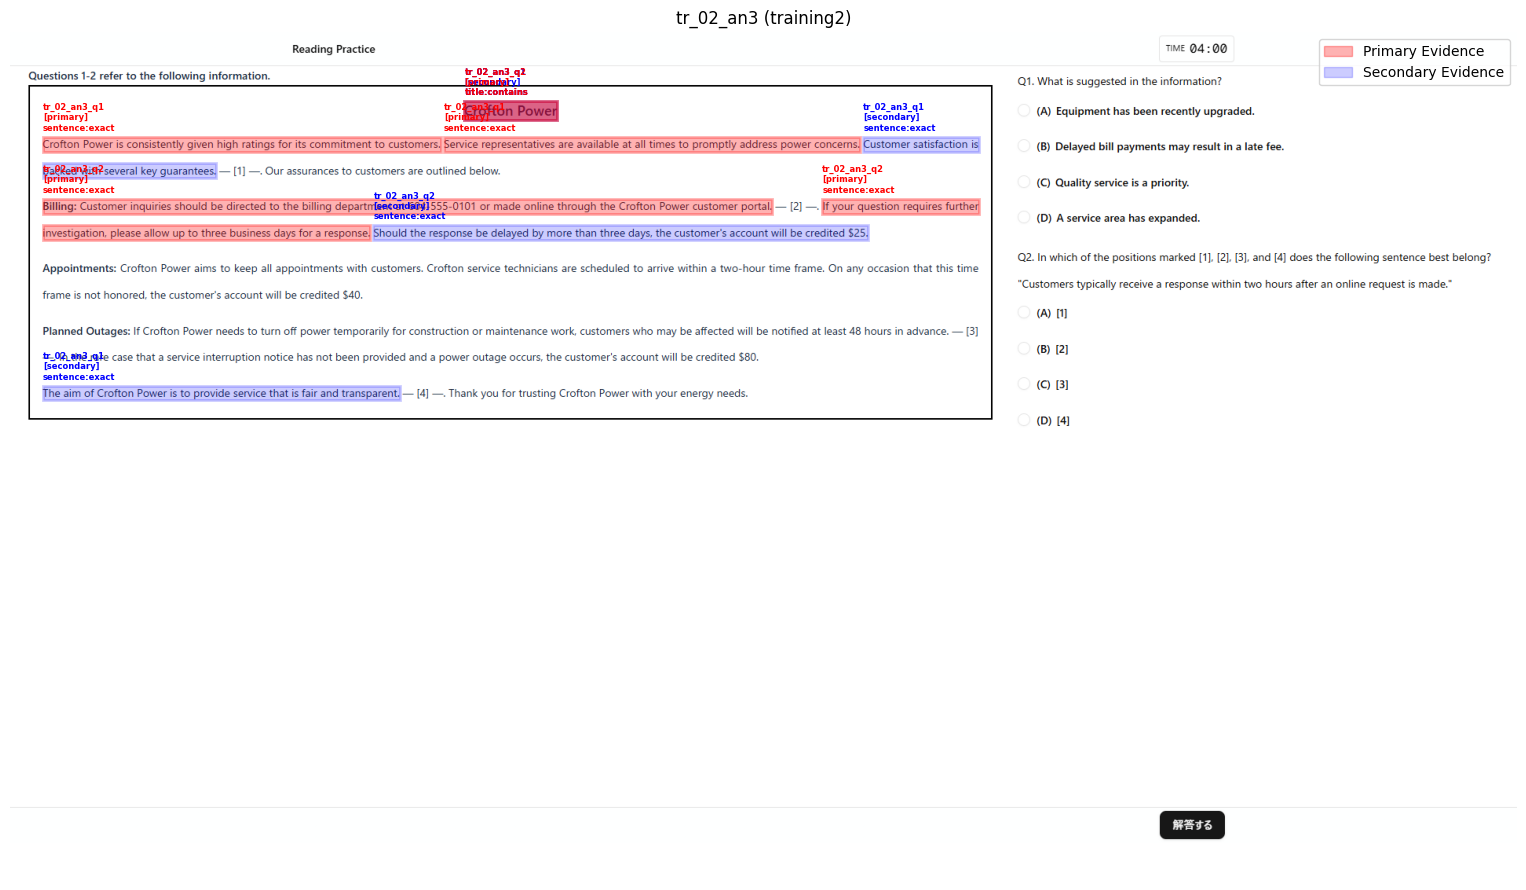

In [37]:
# === TRAINING2 phase ===
print('=== TRAINING2 phase ===')

for passage_id, passage_data in passages_by_phase.get('training2', []):
    phase = passage_data.get('phase', '')
    image_path = find_image_for_passage(passage_id, phase)
    
    print(f"\n{passage_id}")
    if image_path:
        print(f"  Image: {os.path.basename(image_path)}")
    else:
        print("  Image: NOT FOUND")
    
    # 設問ごとの根拠数を表示
    for q_id, q_data in passage_data.get('questions', {}).items():
        evidence_count = len(q_data.get('evidence_sentences', []))
        print(f"  {q_id}: {evidence_count} evidence sentences")
    
    fig = visualize_evidence(passage_id, passage_data, image_path)
    plt.show()
    plt.close()

=== TRAINING3 phase ===

tr_03
  Image: 003_back.png
  tr03_q1: 3 evidence sentences
  tr03_q2: 3 evidence sentences


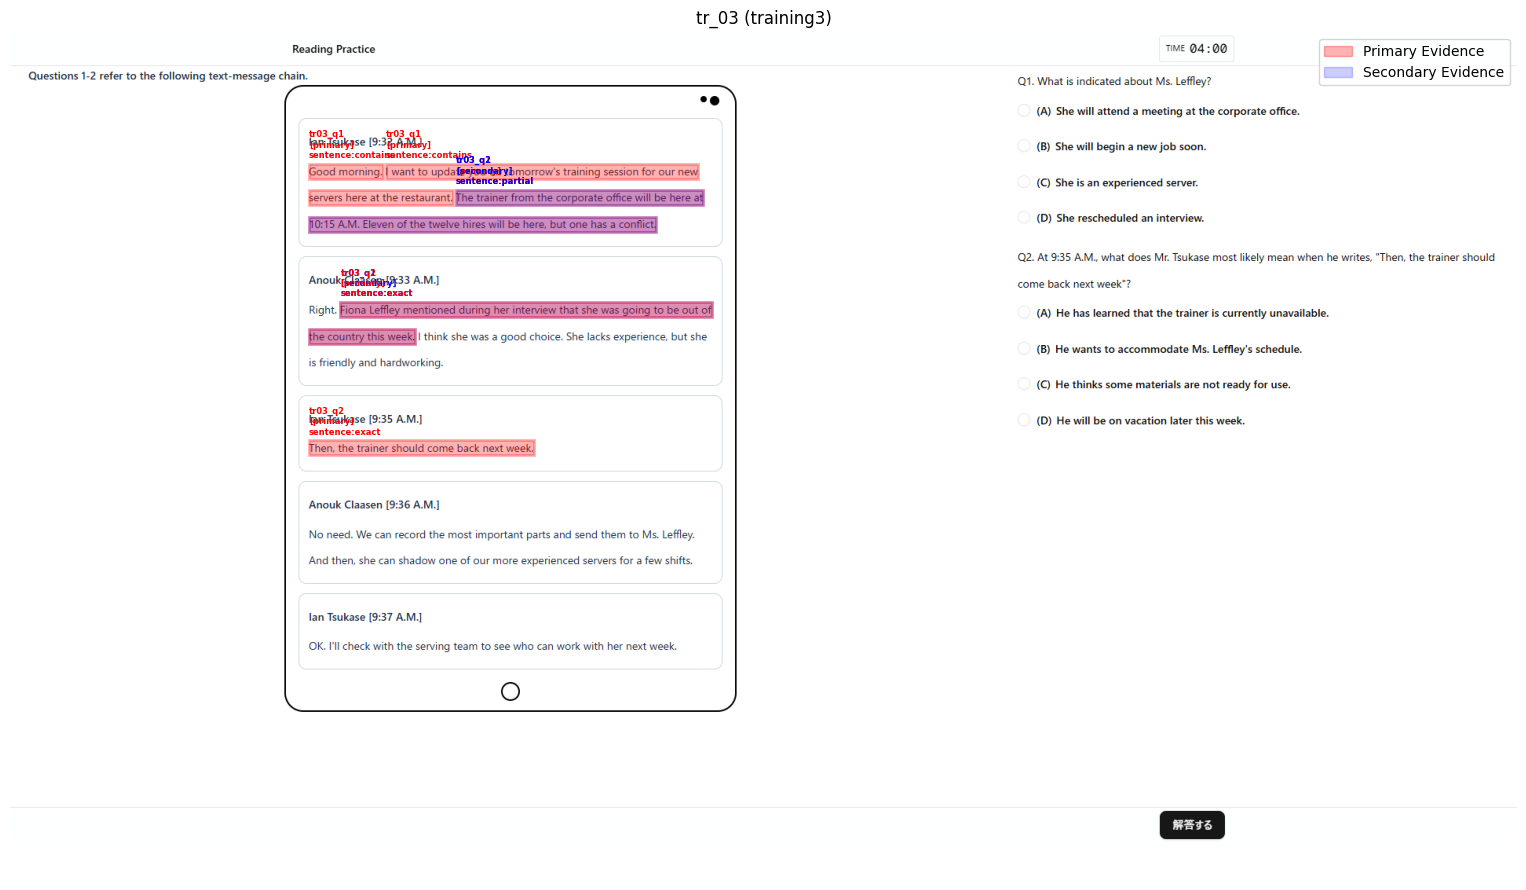


tr_03_an1
  Image: 007_back.png
  tr_03_an1_q1: 3 evidence sentences
  tr_03_an1_q2: 3 evidence sentences
  tr_03_an1_q3: 2 evidence sentences


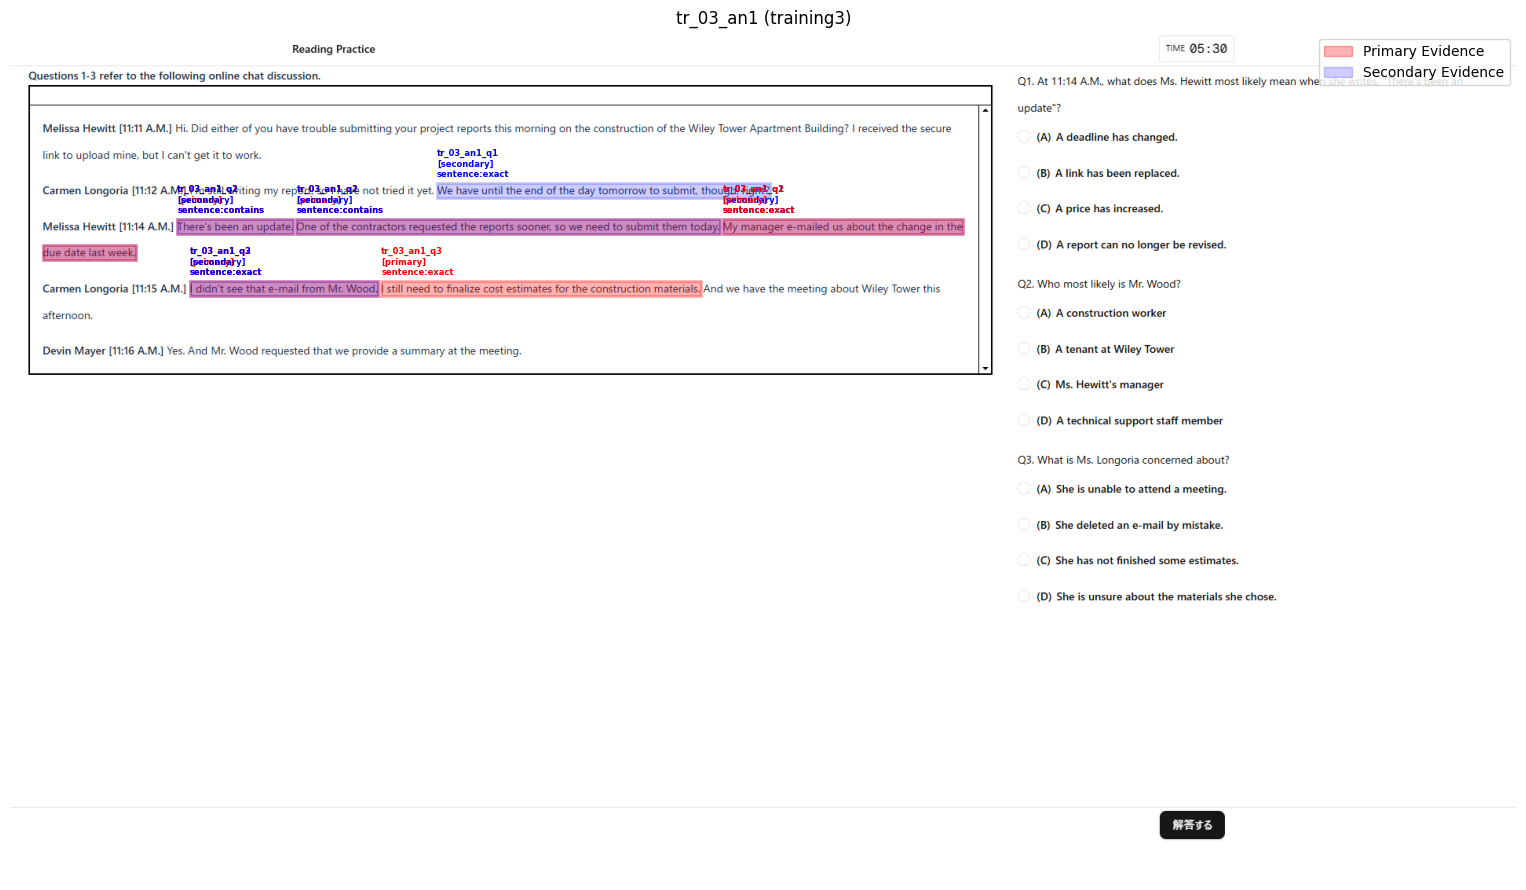


tr_03_an2
  Image: 009_back.png
  tr_03_an2_q1: 3 evidence sentences
  tr_03_an2_q2: 1 evidence sentences


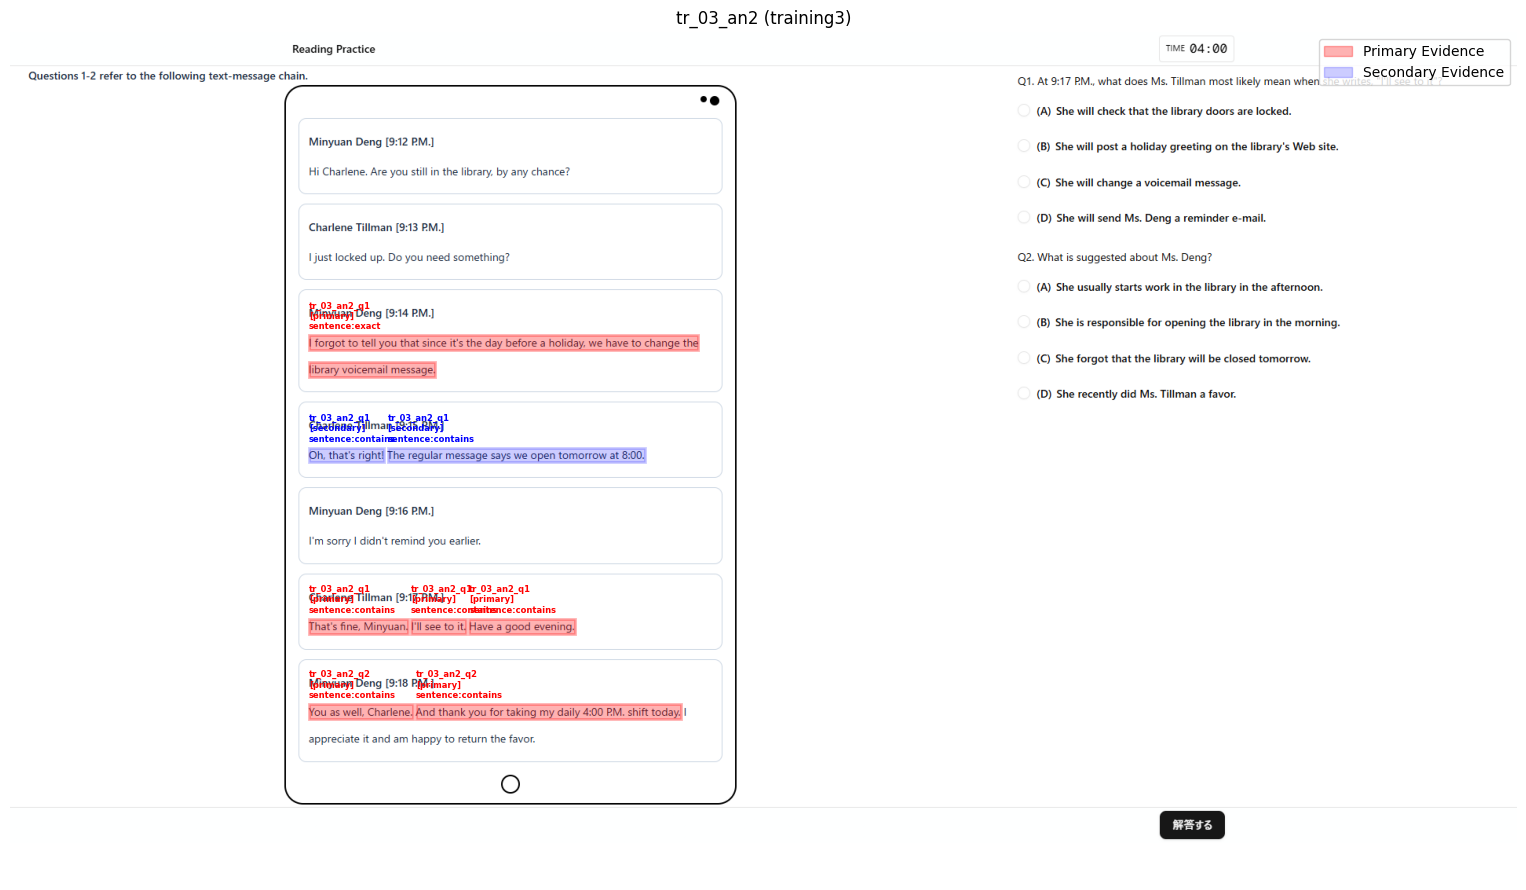


tr_03_an3
  Image: 011_back.png
  tr_03_an3_q1: 3 evidence sentences
  tr_03_an3_q2: 4 evidence sentences


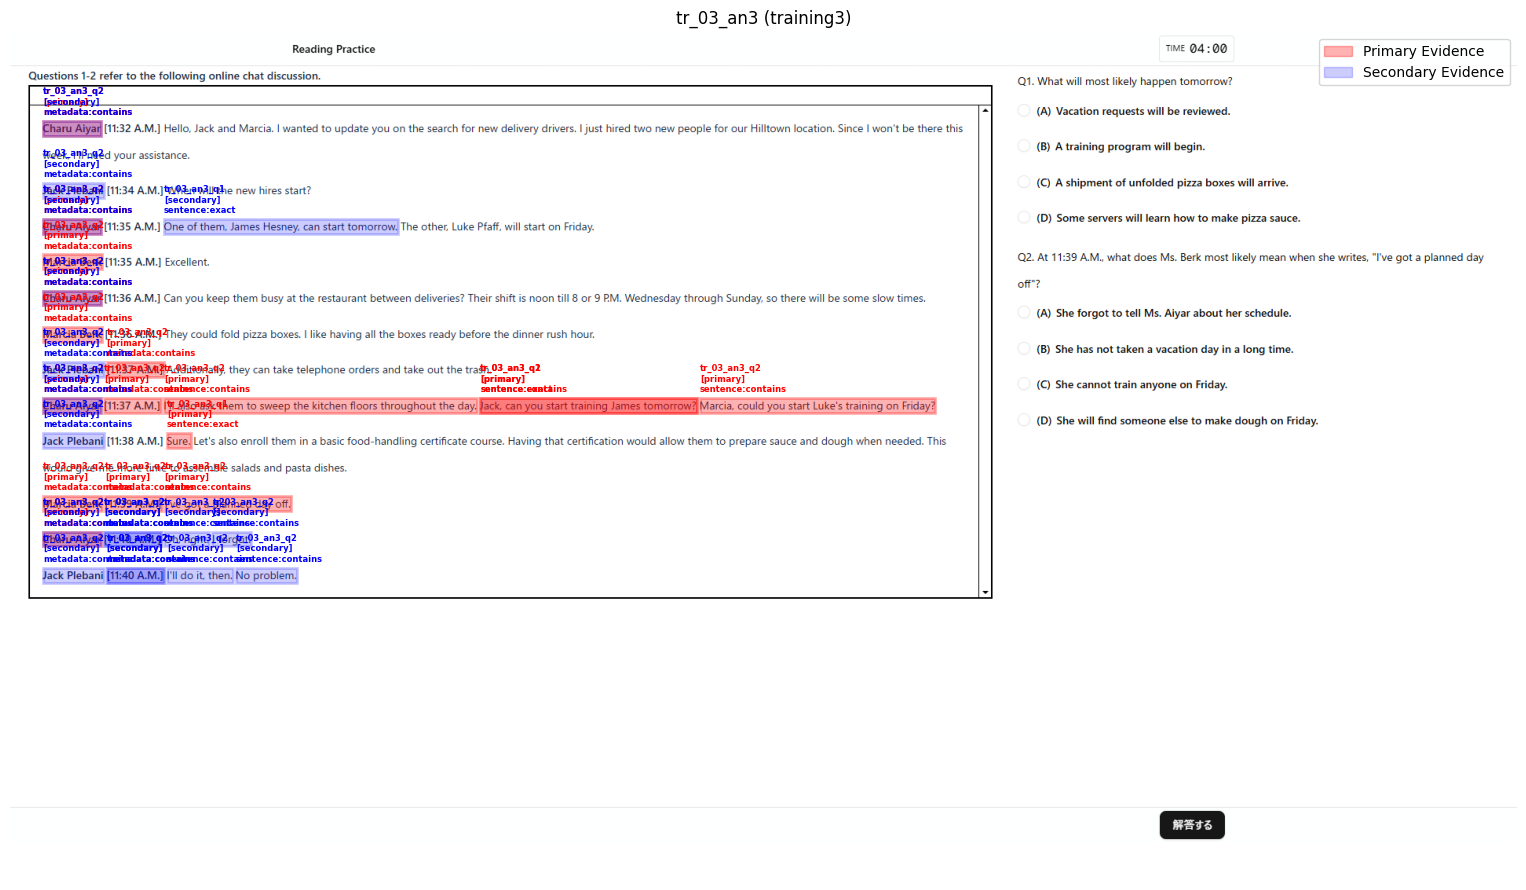

In [38]:
# === TRAINING3 phase ===
print('=== TRAINING3 phase ===')

for passage_id, passage_data in passages_by_phase.get('training3', []):
    phase = passage_data.get('phase', '')
    image_path = find_image_for_passage(passage_id, phase)
    
    print(f"\n{passage_id}")
    if image_path:
        print(f"  Image: {os.path.basename(image_path)}")
    else:
        print("  Image: NOT FOUND")
    
    # 設問ごとの根拠数を表示
    for q_id, q_data in passage_data.get('questions', {}).items():
        evidence_count = len(q_data.get('evidence_sentences', []))
        print(f"  {q_id}: {evidence_count} evidence sentences")
    
    fig = visualize_evidence(passage_id, passage_data, image_path)
    plt.show()
    plt.close()

## 5. 詳細表示（単一問題）

特定の問題について詳細を確認したい場合に使用

In [39]:
def show_evidence_details(passage_id: str):
    """
    特定のパッセージの根拠詳細を表示
    """
    if passage_id not in evidence_data:
        print(f"パッセージ '{passage_id}' が見つかりません")
        return
    
    passage_data = evidence_data[passage_id]
    phase = passage_data.get('phase', '')
    
    print(f"=== {passage_id} ({phase}) ===")
    print()
    
    for q_id, q_data in passage_data.get('questions', {}).items():
        print(f"--- {q_id} ---")
        print(f"Question: {q_data.get('question_text', '')[:80]}...")
        print(f"Correct: {q_data.get('correct_answer', '')}")
        print()
        
        for i, ev in enumerate(q_data.get('evidence_sentences', [])):
            print(f"  Evidence #{i+1} ({ev.get('type', '')})")
            print(f"    Text: {ev.get('original_text', '')[:80]}...")
            print(f"    Reason: {ev.get('reason', '')[:80]}...")
            print()
            
            for match in ev.get('matched_sentences', []):
                print(f"      Match: {match.get('text', '')[:60]}...")
                print(f"        source_type: {match.get('source_type', '')}")
                print(f"        match_type: {match.get('match_type', '')}, sim: {match.get('similarity', 0):.2f}")
                print(f"        lines: {len(match.get('lines', []))} boxes")
                for line in match.get('lines', []):
                    print(f"          ({line['x']}, {line['y']}) {line['width']}x{line['height']}")
            print()
        print()

# 使用例
# show_evidence_details('pre_01')

In [40]:
# 特定のパッセージを詳細表示
show_evidence_details('pre_01')

=== pre_01 (pre) ===

--- pre_01_q1 ---
Question: Q1. At 10:19 A.M., what does Mr. Martinez most likely mean when he writes, "It w...
Correct: D

  Evidence #1 (secondary)
    Text: Rex Martinez [10:16 A.M.] Hello, Tzu-Tsu. Could you please assist me with regard...
    Reason: 話題の中心が「my paycheck（給与支払）」であり、後の it が何を指すか（給与の受け取り）を特定できる。...

      Match: Hello, Tzu-Tsu....
        source_type: sentence
        match_type: contains, sim: 1.00
        lines: 1 boxes
          (205, 113) 86x19
      Match: Could you please assist me with regard to my paycheck?...
        source_type: sentence
        match_type: contains, sim: 1.00
        lines: 1 boxes
          (295, 113) 348x19
      Match: Rex Martinez...
        source_type: metadata
        match_type: contains, sim: 1.00
        lines: 1 boxes
          (42, 113) 83x19
      Match: [10:16 A.M.]...
        source_type: metadata
        match_type: contains, sim: 1.00
        lines: 1 boxes
          (129, 113) 73x19
      Match: Rex Ma

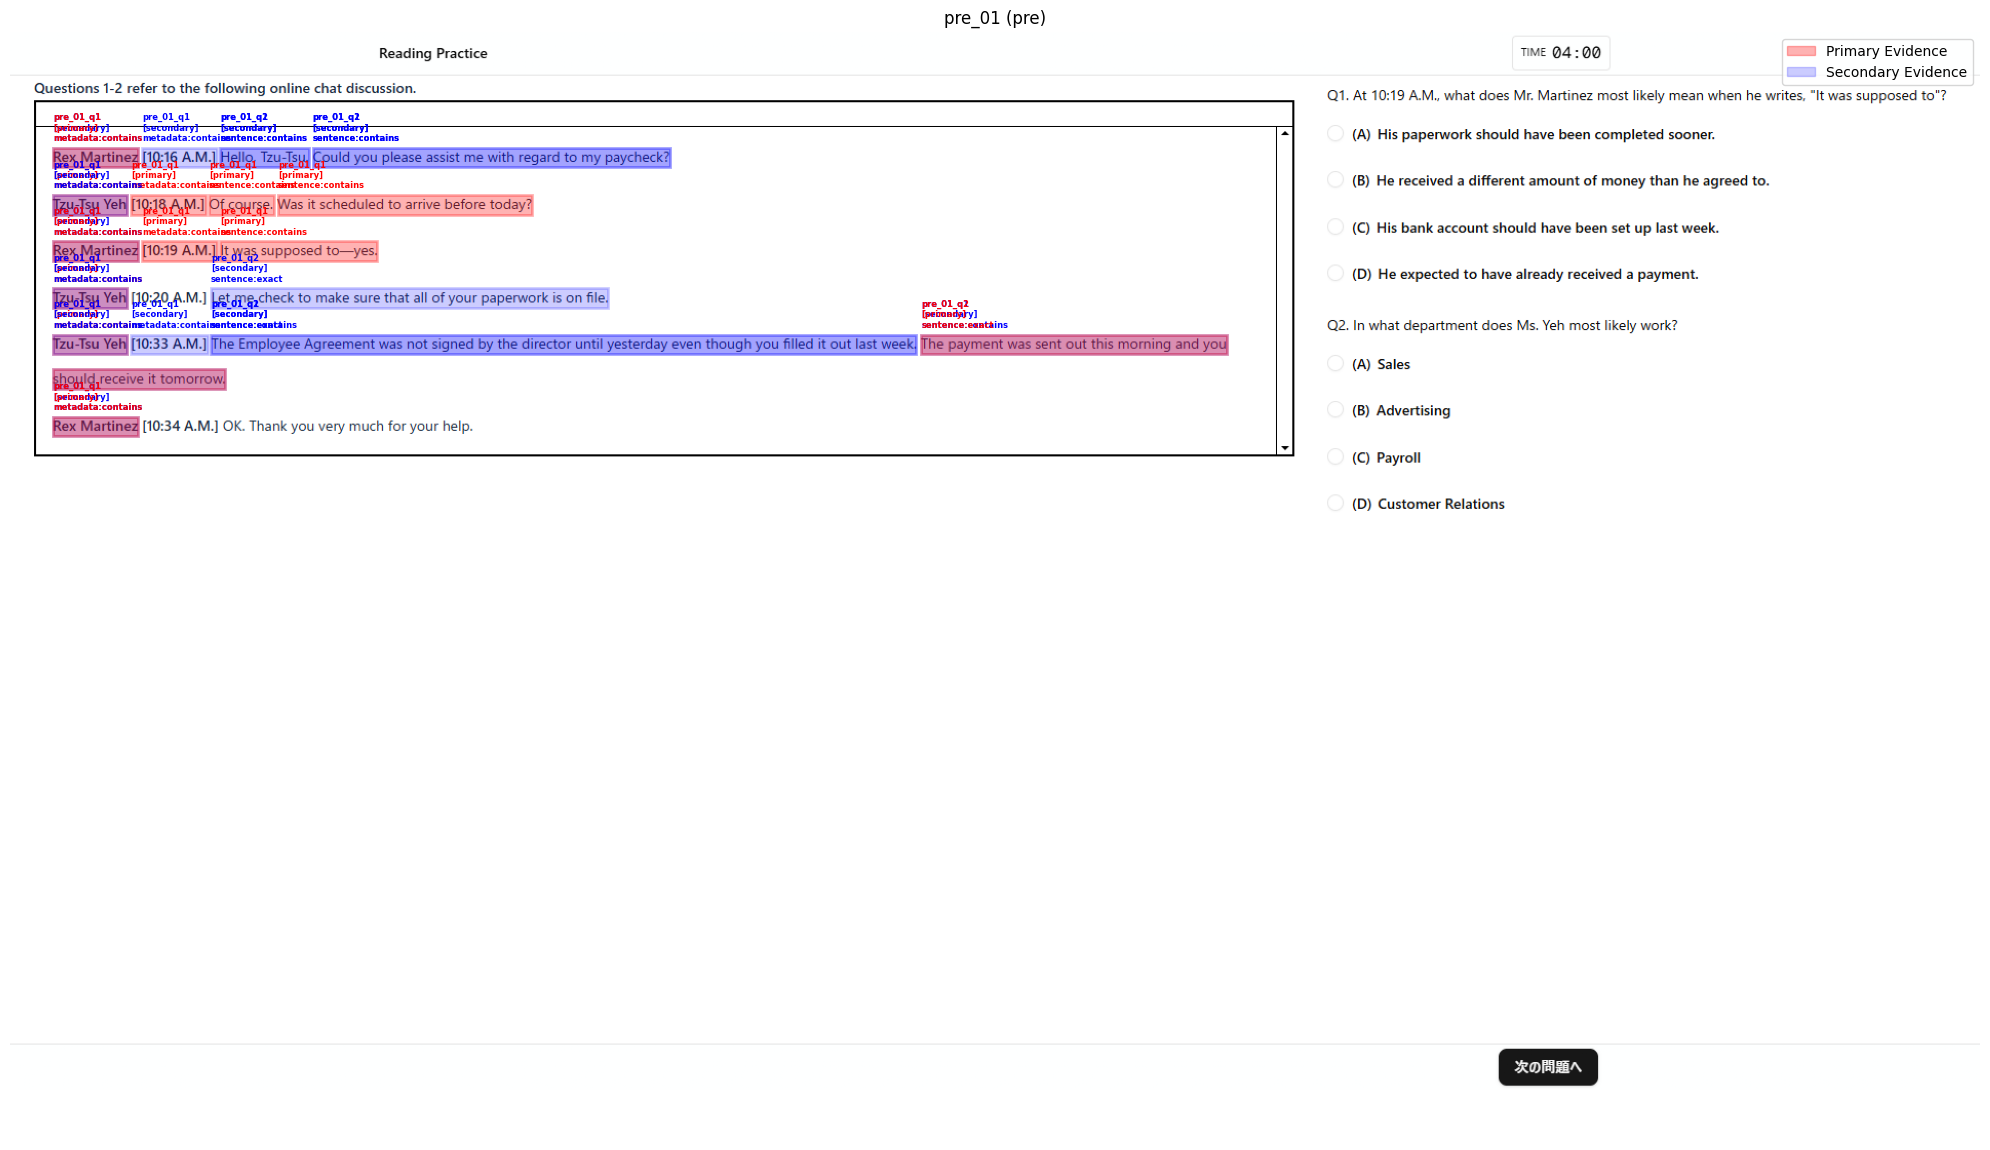

In [41]:
# 特定のパッセージを可視化
target_passage = 'pre_01'
if target_passage in evidence_data:
    passage_data = evidence_data[target_passage]
    phase = passage_data.get('phase', '')
    image_path = find_image_for_passage(target_passage, phase)
    
    fig = visualize_evidence(target_passage, passage_data, image_path, figsize=(20, 12))
    plt.show()
else:
    print(f"パッセージ '{target_passage}' が見つかりません")

## 6. マッチング統計

根拠座標のマッチング結果を集計

In [42]:
# マッチング統計を集計
stats = {
    'total_questions': 0,
    'total_evidence': 0,
    'total_matches': 0,
    'match_types': {},
    'source_types': {},
    'unmatched_evidence': [],
}

for passage_id, passage_data in evidence_data.items():
    for q_id, q_data in passage_data.get('questions', {}).items():
        stats['total_questions'] += 1
        
        for ev in q_data.get('evidence_sentences', []):
            stats['total_evidence'] += 1
            
            matches = ev.get('matched_sentences', [])
            if not matches:
                stats['unmatched_evidence'].append({
                    'question_id': q_id,
                    'text': ev.get('original_text', '')[:80],
                })
            
            for match in matches:
                stats['total_matches'] += 1
                
                mt = match.get('match_type', 'unknown')
                stats['match_types'][mt] = stats['match_types'].get(mt, 0) + 1
                
                st = match.get('source_type', 'unknown')
                stats['source_types'][st] = stats['source_types'].get(st, 0) + 1

print('=== マッチング統計 ===')
print(f'総設問数: {stats["total_questions"]}')
print(f'総根拠数: {stats["total_evidence"]}')
print(f'総マッチ数: {stats["total_matches"]}')
print()

print('マッチタイプ別:')
for mt, count in sorted(stats['match_types'].items(), key=lambda x: -x[1]):
    pct = count / stats['total_matches'] * 100 if stats['total_matches'] > 0 else 0
    print(f'  {mt}: {count} ({pct:.1f}%)')
print()

print('ソースタイプ別:')
for st, count in sorted(stats['source_types'].items(), key=lambda x: -x[1]):
    pct = count / stats['total_matches'] * 100 if stats['total_matches'] > 0 else 0
    print(f'  {st}: {count} ({pct:.1f}%)')
print()

print(f'マッチなし: {len(stats["unmatched_evidence"])}件')
for item in stats['unmatched_evidence'][:5]:
    print(f'  {item["question_id"]}: {item["text"]}...')

=== マッチング統計 ===
総設問数: 69
総根拠数: 186
総マッチ数: 353

マッチタイプ別:
  contains: 207 (58.6%)
  exact: 136 (38.5%)
  partial: 7 (2.0%)
  fuzzy: 3 (0.8%)

ソースタイプ別:
  sentence: 210 (59.5%)
  metadata: 76 (21.5%)
  table_cell: 46 (13.0%)
  table_header: 12 (3.4%)
  table_row: 5 (1.4%)
  title: 3 (0.8%)
  subtitle: 1 (0.3%)

マッチなし: 0件


## 7. Summary

In [43]:
print('=== 検証サマリー ===')
print(f'総パッセージ数: {len(evidence_data)}')
print()

for phase in ['pre', 'post', 'training1', 'training2', 'training3']:
    passages = passages_by_phase.get(phase, [])
    total_q = sum(len(p[1].get('questions', {})) for p in passages)
    total_ev = sum(
        sum(len(q.get('evidence_sentences', [])) for q in p[1].get('questions', {}).values())
        for p in passages
    )
    print(f'{phase}: {len(passages)} passages, {total_q} questions, {total_ev} evidence sentences')

=== 検証サマリー ===
総パッセージ数: 28

pre: 8 passages, 20 questions, 54 evidence sentences
post: 8 passages, 20 questions, 55 evidence sentences
training1: 4 passages, 10 questions, 26 evidence sentences
training2: 4 passages, 10 questions, 26 evidence sentences
training3: 4 passages, 9 questions, 25 evidence sentences
